# Data input and preprocessing

In [2]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from collections import defaultdict
from scipy.stats import reciprocal, uniform
from sklearn.linear_model import (LinearRegression, Ridge, RidgeCV, LassoCV)
from sklearn.model_selection import RandomizedSearchCV
rf=RandomForestRegressor(random_state=42)
lr=LinearRegression(normalize=True)
%matplotlib inline

plt.style.use('ggplot','fivethirtyeight')

In [2]:
# LOAD RESPONSE DATA--THE TARGET

In [154]:
# load target dataset
response=pd.read_csv('Response_training.txt',sep='\t',index_col=0)
response=response.sort_index()
labels=response.copy()
labels=labels.drop(['HCC1569', 'SUM229PE', 'T47DKBLUC'])
#print(labels)
drug_names=[name for name in response.columns if name !='CellLine']
# load dataset
test_celllines=['184A1','184B5','21MT1','21NT','600MPE','HCC2185','HCC3153','LY2','MCF10A',
'MX1','SKBR3','SUM1315MO2','SUM149PT','SUM159PT','SUM185PE','SUM225CWN','SUM52PE','ZR75B']
# genes dataset 
genes=pd.read_csv('GeneExpression.txt',sep='\t',index_col=0)
genes_train=genes[[cell for cell in list(genes) if cell not in test_celllines]].T.sort_index()
genes_test=genes[[cell for cell in list(genes) if cell in test_celllines]].T.sort_index()
celllines=genes_train.index
# rna dataset
rna=pd.read_csv('RNAseq_quantification.txt',sep='\t',index_col=0)
rna=rna.drop('Ensembl_ID',axis=1).sort_index()
duplicated=rna.index.get_duplicates() # identify all duplicated index---genes
print(len(list(duplicated)))
rna_dup=rna.loc[duplicated] # get all duplicated genes
rna_dup=rna_dup.loc[(rna_dup !=0).all(axis=1)] # get all duplicated genes where the cell lines have value
rna_dup=rna_dup.reset_index().drop_duplicates(subset='HGNC_ID',keep='first').set_index('HGNC_ID') # remove duplicated genes
rna=rna.drop(duplicated)# completely remove all all duplicated genes from rna data
combo=rna.T.join(rna_dup.T,how='outer').T # combine unduplicated rna dataset by cell line
rna_train=combo[[cell for cell in list(rna) if cell not in test_celllines]].T.sort_index()
rna_test=combo[[cell for cell in list(rna) if cell in test_celllines]].T.sort_index()

1612


In [1]:
# drugs with same values affects feature selection

In [424]:
# CREATE A METHOD TO EVALUATE PERFORMANCE
def evaluate(model, test_features, test_labels,model_name):
    predictions = model.predict(test_features) # perform prediction using selected features
    #print(list(zip(predictions,test_labels))) # uncomment if you want to see actual predictions
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    print(mape)
    accuracy = 100 - mape
    #print('  Performance: %s' % model_name) # 
    #print('  Average Error: {:0.4f} μM.'.format(np.mean(errors)))
    #print('  Accuracy = {:0.2f}%.'.format(accuracy))
    #print(' ')
    return accuracy
def predict(model, test_features,drug):
   #test_label={}
   predictions = model.predict(test_features) # perform prediction using selected features
   celllines=list(test_features.index)
   #output=(list(zip(celllines,predictions))) # uncomment if you want to see actual predictions
   output=predictions
   #test_label[drug]=output
   #print(output)
   return output
def plot_learning_curves(model, X, y,drug,method):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2,random_state=42)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    #print(np.sqrt(train_errors))
    #print(np.sqrt(val_errors))
    plt.plot(np.sqrt(train_errors), "r-", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.ylim(0,1)
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE(log(y))", fontsize=14)
    plt.title('Learning curve for %s'%drug,fontsize=16)
    plt.savefig('Learning_curve for %s_%s.png'%(drug,method),dpi=300,bbox_inches='tight')
    plt.show()

In [425]:
# GENE EXPRESSION FEATURE SELECTION

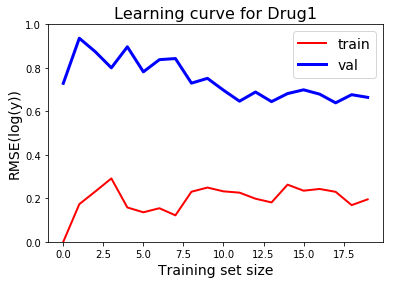

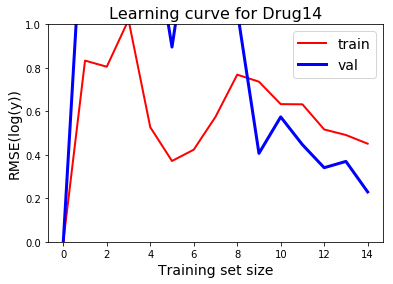

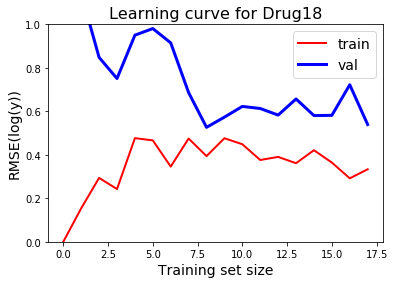

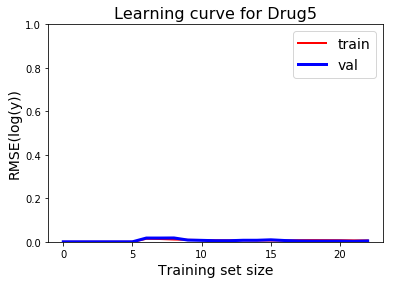

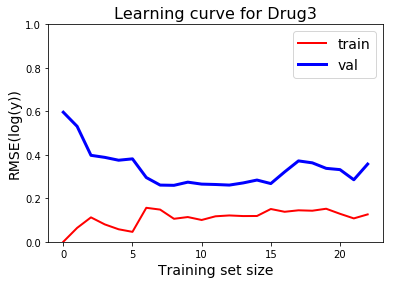

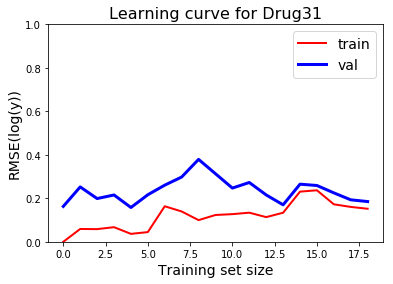

In [436]:
#test_labels_no_fs={}
#dropped={}
plots=['Drug1','Drug14','Drug18','Drug5','Drug3','Drug31']
for drug in plots[:]:
    # DATA CLEANING AND HOMOGENIZATION 
    # select each drug, set index to cell line and drop rows with nan
    label=labels[drug].dropna()
    drop=[cell for cell in labels.index if cell not in label.index]
    dropped[drug]=drop
    X=genes_train.copy()
    # select and sort celllines that has actual response values or exist in gene expression dataset and each drug 
    cellline=[var for var in list(X.index) if var in list(label.index)]
    cellline=sorted(cellline)
    X=X.loc[cellline] # gene expression dataset
    y=label.loc[cellline] # drug response values
    # FEATURE SELECTION 
    #print(X.shape)
    plot_learning_curves(rf,X,y,drug,'rf_base')
    #X_test=genes_test.copy()
    #rf.fit(X,y)
    #evaluate(rf,X,y,'base_rf')
    #X_test=X_test.append(genes_train.loc[dropped])
    #print(X_test.index)
    #plot_learning_curves(rf,X[f].loc[cellline],label.loc[cellline],drug)
    #test_labels_no_fs[drug]=predict(rf,X_test,drug)
#gene_predict_no_fs=pd.DataFrame(test_labels_no_fs, columns=list(test_labels_no_fs.keys()),index=list(X_test.index))

In [437]:
# mean accuracy feature selection using 10 cross validation using gene expression data
#test_labels_fs={}
#gene_features={}
#correlated_genes={} # cut off at 0.5
#correlated_genes_2={}
for drug in drug_names[:]:
    #if drug=='Drug26':continue
    #scores_gene = defaultdict(list)
    print('Processing %s'% drug)
    # DATA CLEANING AND HOMOGENIZATION 
    # select each drug, set index to cell line and drop rows with nan
    label=labels[drug].dropna()
    X=genes_train.copy()
    corr=abs(X.corrwith(label))
    #gene_list=list(corr[corr.values>0.5].index)# correlated_genes
    gene_list2=list(corr[corr.values>0.3].index) # correlated_genes_2
    #print(gene_list)
    #gene_list=list(corr[corr.values>0.001].index)
    correlated_genes_2[drug]=gene_list2
    #print(len(gene_list))
    # select and sort celllines that has actual response values or exist in gene expression dataset and each drug 
    #cellline=[var for var in list(X.index) if var in list(label.index)]
    #cellline=sorted(cellline)
    #X=X[gene_list].loc[cellline] # gene expression dataset
    #y=label.loc[cellline] # drug response values
    # FEATURE SELECTION 
    #print(X.shape)
    #features=list(X) # list of genes in gene expression dataset 
    #crossvalidate the scores on a number of different random splits of the data
    #rs=ShuffleSplit(10,.2)
    #for train_idx, test_idx in rs.split(X):
     #   X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
     #   Y_train, Y_test = y.iloc[train_idx], y.iloc[test_idx]
     #   r = rf.fit(X_train, Y_train)
     #   acc = r2_score(Y_test, rf.predict(X_test))
      #  for i in range(X.shape[1]):
      #      X_t = X_test.copy()
      #      np.random.shuffle(X_t.iloc[:, i])
      #      shuff_acc = r2_score(Y_test, rf.predict(X_t))
            #print('shuffle',shuff_acc)
      #      scores_gene[features[i]].append((acc-shuff_acc)/acc)
    #feature_importance=sorted([(round(np.mean(score), 4), feat) for
    #          feat, score in scores_gene.items() if np.mean(score)>0.02], reverse=True)
    #gene_features[drug]=feature_importance
    #best_features=[feat for score,feat in feature_importance]
    #if len(best_features)>0:
     #   plot_learning_curves(rf,X[best_features],y,drug)
     #   X_test=genes_test.copy()
     #   rf.fit(X[best_features],y)
    #plot_learning_curves(rf,X[f].loc[cellline],label.loc[cellline],drug)
     #   test_labels_fs[drug]=predict(rf,X_test[best_features],drug)
#gene_predict_fs=pd.DataFrame(test_labels_fs, columns=list(test_labels_fs.keys()),index=list(genes_test.index))

Processing Drug1
Processing Drug2


KeyboardInterrupt: 

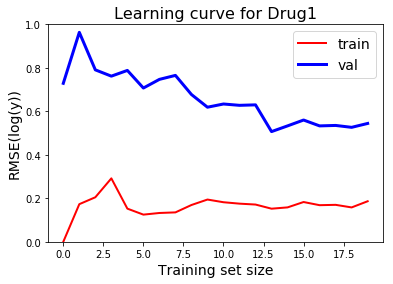

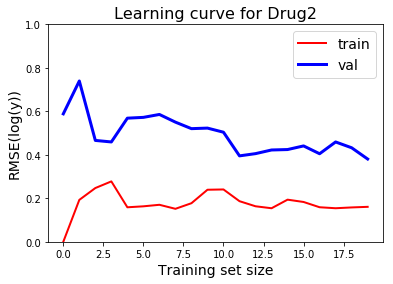

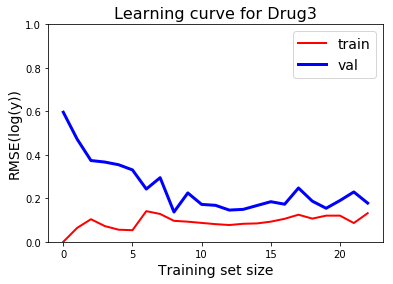

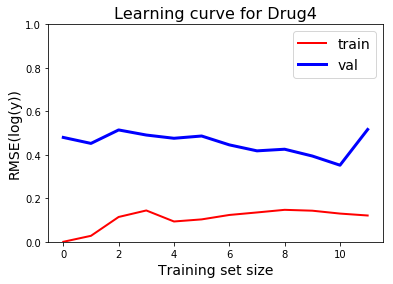

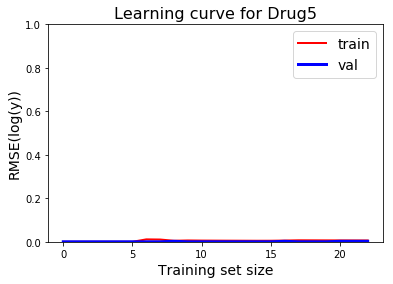

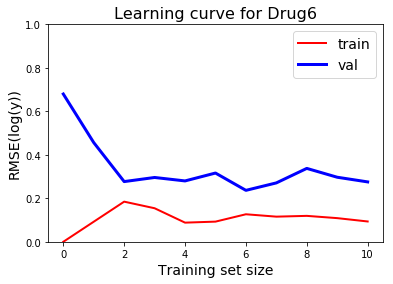

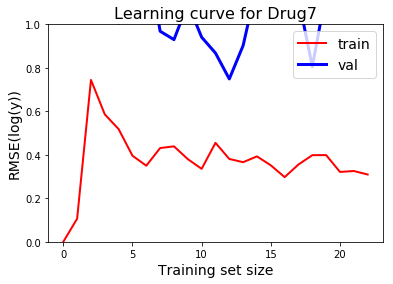

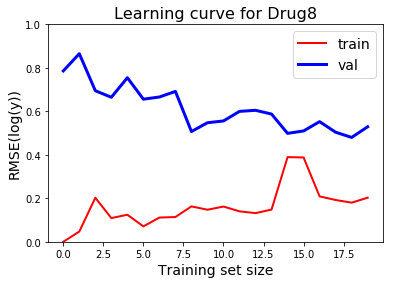

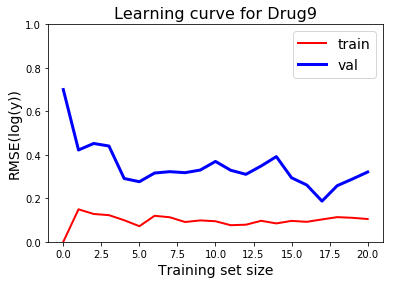

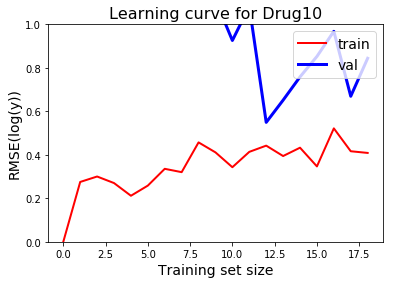

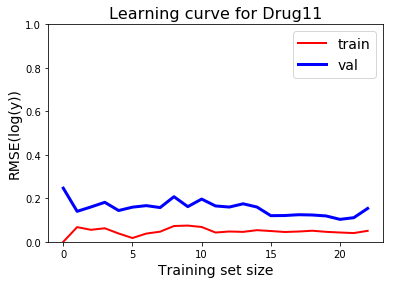

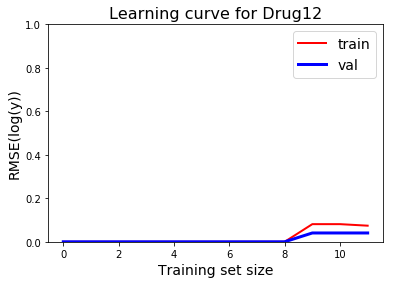

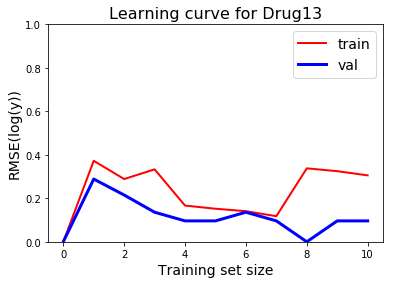

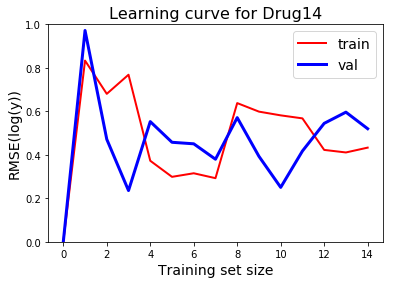

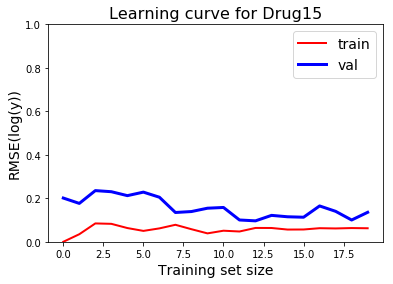

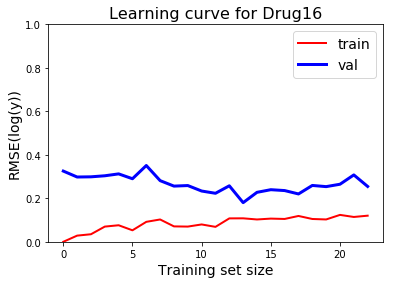

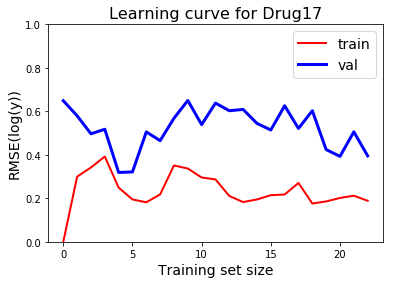

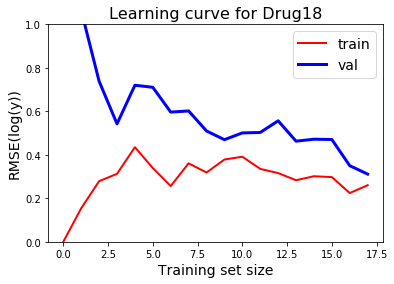

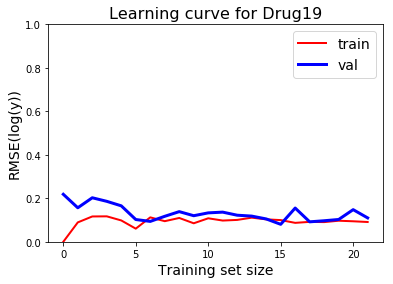

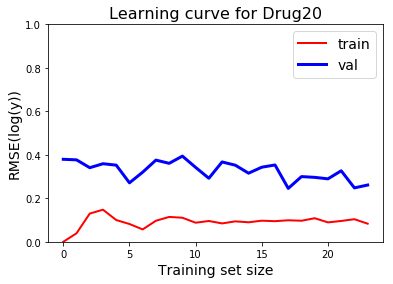

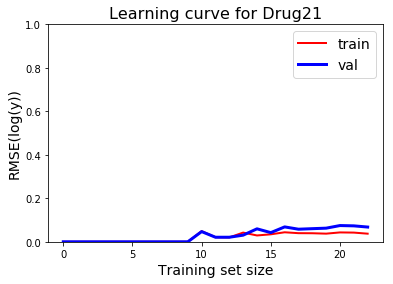

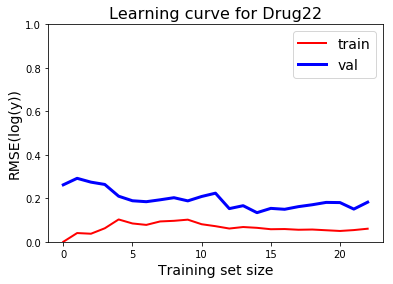

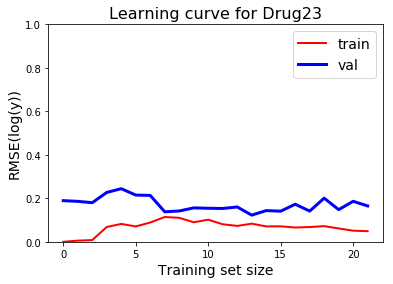

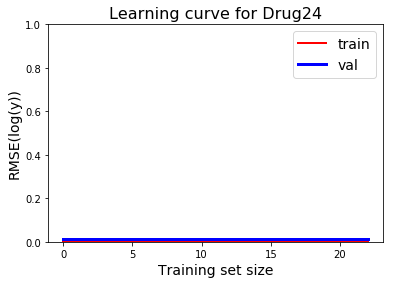

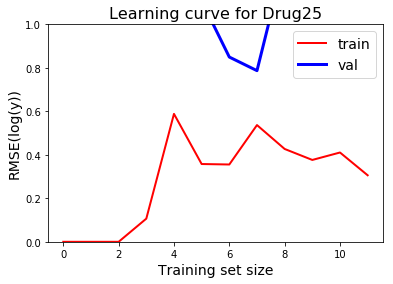

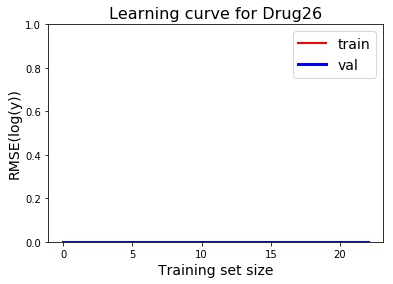

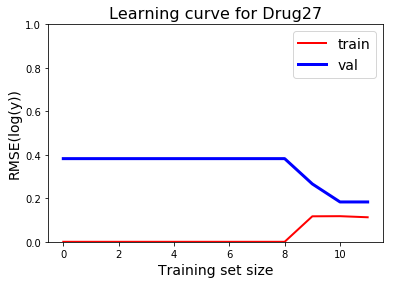

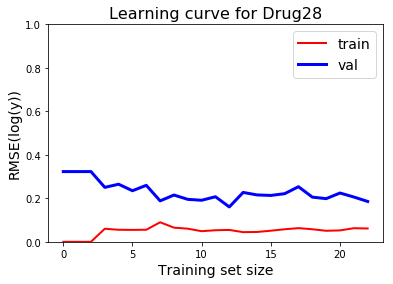

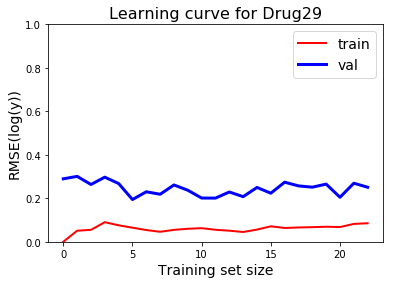

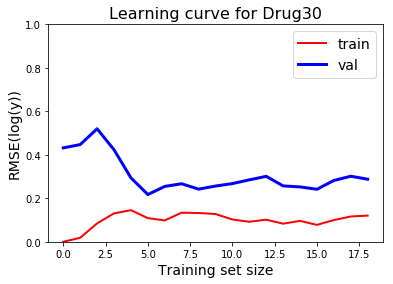

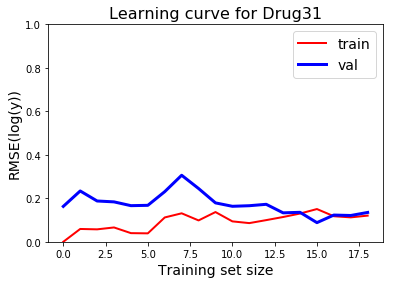

In [382]:
# random regression base model with correlated genes with 0.5 threshold
test_correlated_rf={}
drop_correlated_rf={}
for drug in drug_names:
    label=labels[drug].dropna()
    X=genes_train.copy()
    cellline=[var for var in list(X.index) if var in list(label.index)]
    cellline=sorted(cellline)
    X_test=genes_test.copy()
    # select and sort celllines that has actual response values or exist in gene expression dataset and each drug 
    if len(correlated_genes[drug])>0:
        X=X[correlated_genes[drug]].loc[cellline]
        X_test=X_test[correlated_genes[drug]]
    if len(correlated_genes[drug])==0:
        X=X.loc[cellline]
    y=label.loc[cellline] # drug response values
    plot_learning_curves(rf,X,y,drug)
    rf.fit(X,y)
    test_correlated_rf[drug]=predict(rf,X_test,drug)
    line=dropped[drug]
    if len(line)!=0 and len(correlated_genes[drug])>0:
        X_drop=genes_train[correlated_genes[drug]].loc[line]
        pred=predict(rf,X_drop,drug)
        drop_correlated_rf[drug]=list(zip(dropped[drug],pred))
    if len(line) !=0 and len(correlated_genes[drug])==0:
        X_drop=genes_train.loc[line]
        pred=predict(rf,X_drop,drug)
        drop_correlated_rf[drug]=list(zip(dropped[drug],pred))
gene_correlated_rf=pd.DataFrame(test_correlated_rf, 
                                columns=list(test_correlated_rf.keys()),index=list(genes_test.index))
all_celllines_correlated_rf=gene_correlated_rf.append(response)
for drug in drop_correlated_rf.keys():
    for i in range(len(drop_correlated_rf[drug])):
        all_celllines_correlated_rf.loc[drop_correlated_rf[drug][i][0],drug]=drop_correlated_rf[drug][i][1]
ranked_correlated_rf=pd.DataFrame(index=[i for i in all_celllines_correlated_rf.index])
for drug in all_celllines_correlated_rf:
    ranked_correlated_rf[drug]=np.argsort(-all_celllines_correlated_rf[drug].sort_values(ascending=False))+1
ranked_correlated_rf.index.name='DrugAnonID'
ranked_correlated_rf.to_csv('../scoring/dream7_drugsensitivity1_predictions_JE_correlated_rf.csv',index=True)


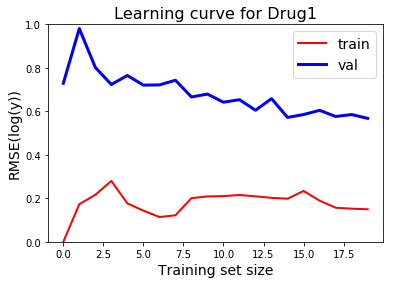

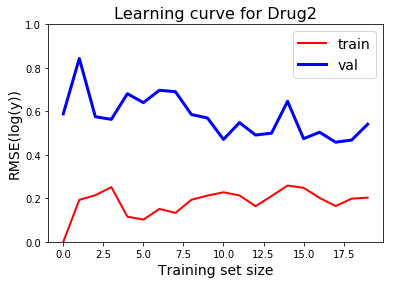

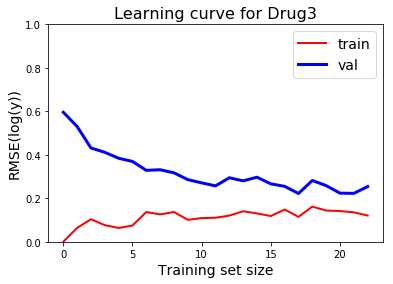

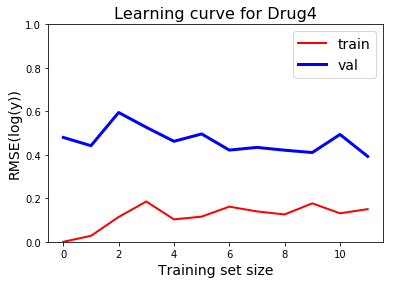

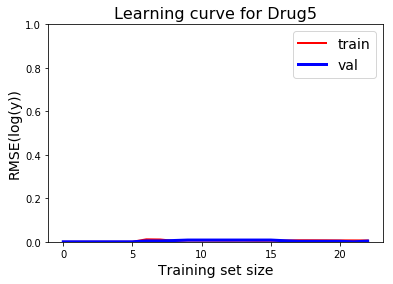

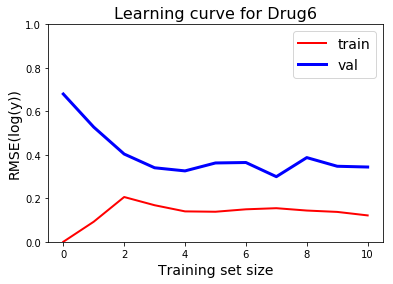

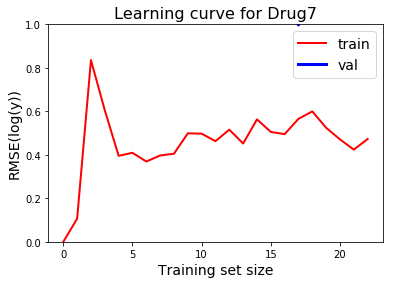

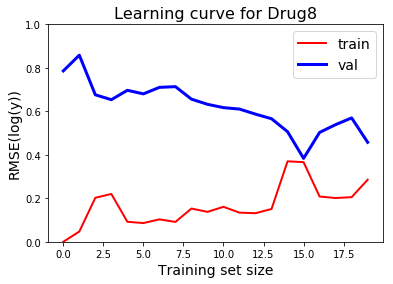

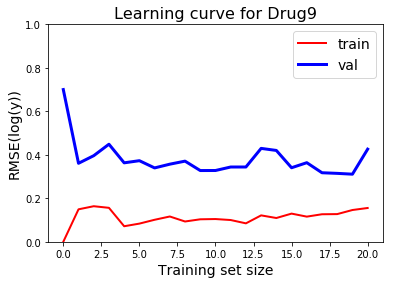

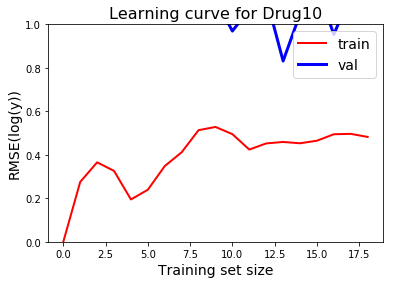

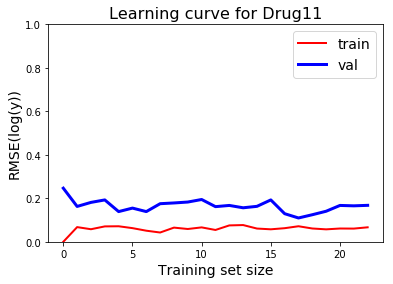

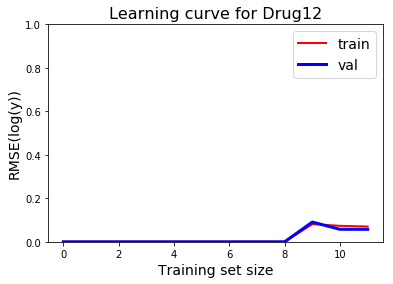

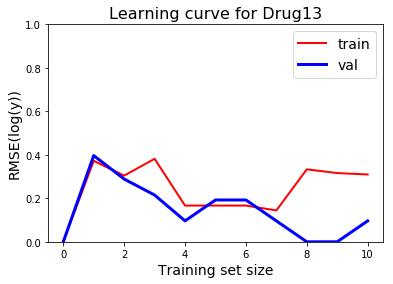

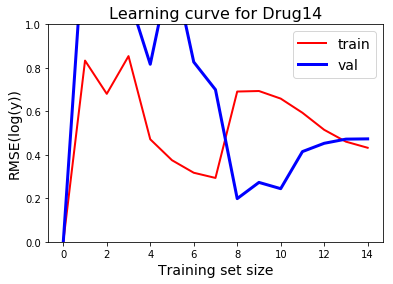

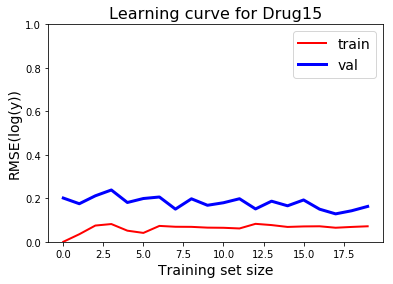

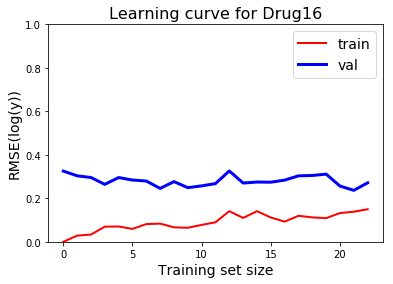

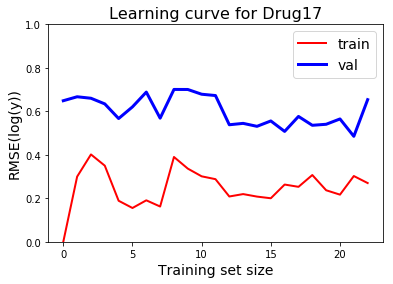

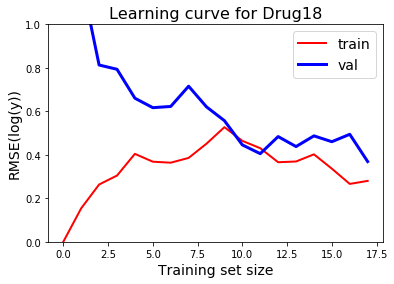

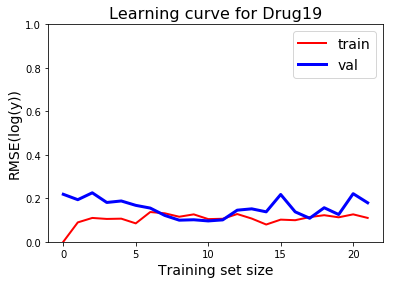

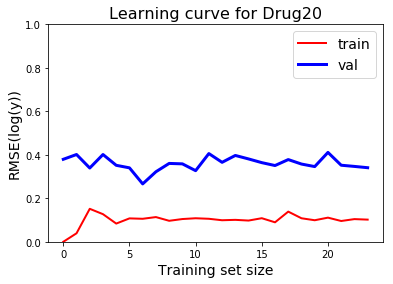

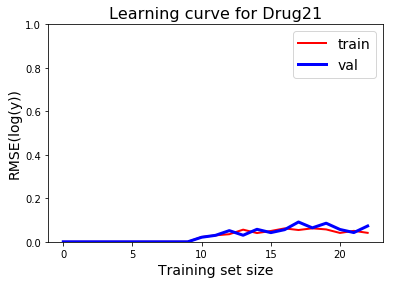

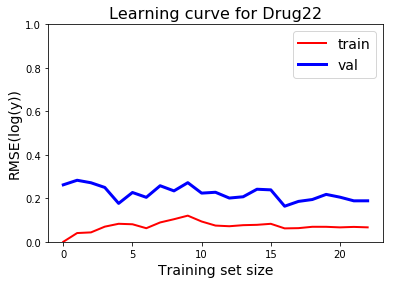

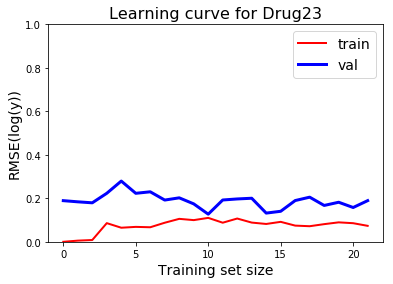

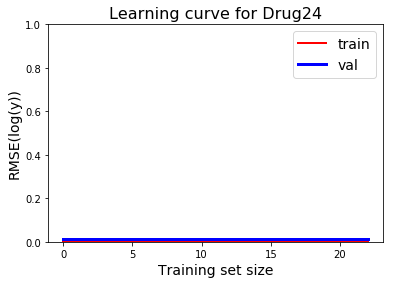

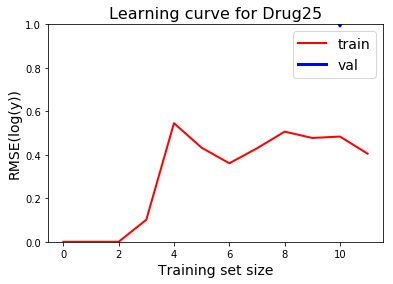

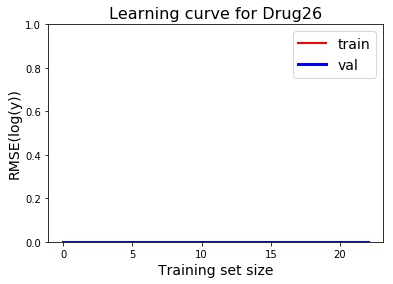

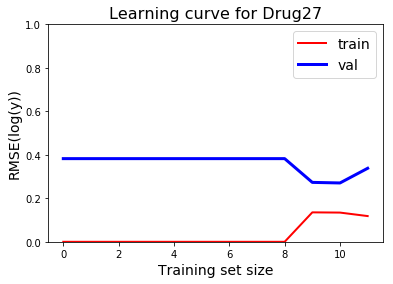

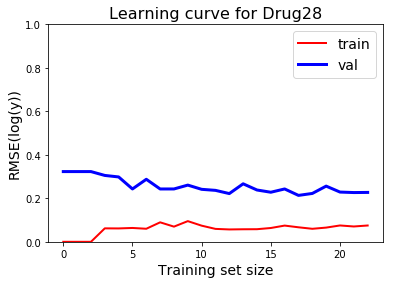

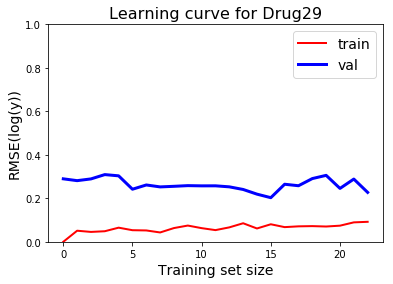

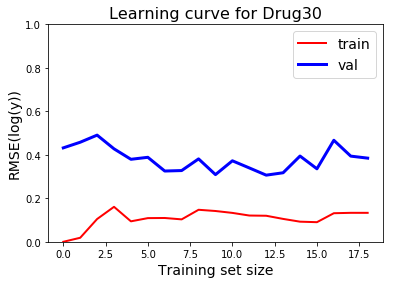

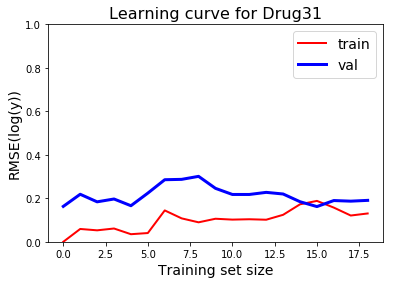

In [383]:
['Drug1','Drug14','Drug18','Drug5','Drug3']
# random regression base model with correlated genes with 0.3 threshold
test_correlated_rf2={}
drop_correlated_rf2={}
for drug in drug_names:
    label=labels[drug].dropna()
    X=genes_train.copy()
    cellline=[var for var in list(X.index) if var in list(label.index)]
    cellline=sorted(cellline)
    X_test=genes_test.copy()
    # select and sort celllines that has actual response values or exist in gene expression dataset and each drug 
    if len(correlated_genes_2[drug])>0:
        X=X[correlated_genes_2[drug]].loc[cellline]
        X_test=X_test[correlated_genes_2[drug]]
    if len(correlated_genes_2[drug])==0:
        X=X.loc[cellline]
    y=label.loc[cellline] # drug response values
    plot_learning_curves(rf,X,y,drug)
    rf.fit(X,y)
    test_correlated_rf2[drug]=predict(rf,X_test,drug)
    line=dropped[drug]
    if len(line)!=0 and len(correlated_genes_2[drug])>0:
        X_drop=genes_train[correlated_genes_2[drug]].loc[line]
        pred=predict(rf,X_drop,drug)
        drop_correlated_rf2[drug]=list(zip(dropped[drug],pred))
    if len(line) !=0 and len(correlated_genes_2[drug])==0:
        X_drop=genes_train.loc[line]
        pred=predict(rf,X_drop,drug)
        drop_correlated_rf2[drug]=list(zip(dropped[drug],pred))
gene_correlated_rf2=pd.DataFrame(test_correlated_rf2, 
                                columns=list(test_correlated_rf2.keys()),index=list(genes_test.index))
all_celllines_correlated_rf2=gene_correlated_rf2.append(response)
for drug in drop_correlated_rf2.keys():
    for i in range(len(drop_correlated_rf2[drug])):
        all_celllines_correlated_rf2.loc[drop_correlated_rf2[drug][i][0],drug]=drop_correlated_rf2[drug][i][1]
ranked_correlated_rf2=pd.DataFrame(index=[i for i in all_celllines_correlated_rf2.index])
for drug in all_celllines_correlated_rf2:
    ranked_correlated_rf2[drug]=np.argsort(-all_celllines_correlated_rf2[drug].sort_values(ascending=False))+1
ranked_correlated_rf2.index.name='DrugAnonID'
ranked_correlated_rf2.to_csv('../scoring/dream7_drugsensitivity1_predictions_JE_correlated_rf2.csv',index=True)



In [293]:
#dropped predict with feature selection model
drop_predict_fs={}
for drug in drug_names:
    if drug == 'Drug26':continue
    label=labels[drug].dropna()
    X=genes_train.copy()
    # select and sort celllines that has actual response values or exist in gene expression dataset and each drug 
    cellline=[var for var in list(X.index) if var in list(label.index)]
    cellline=sorted(cellline)
    features=[key for val,key in gene_features[drug]]
    X=X[features].loc[cellline] # gene expression dataset
    y=label.loc[cellline] # drug response values
    # FEATURE SELECTION 
    #print(X.shape)
    #plot_learning_curves(rf,X,y,drug)
    line=dropped[drug]
    if len(line)>0 and X.shape[1] !=0:
        X_test=genes_train.loc[line]
        rf.fit(X,y)
        pred=predict(rf,X_test[features],drug)
        drop_predict_fs[drug]=list(zip(dropped[drug],pred))


In [322]:
col=['Drug1','Drug2','Drug3','Drug4','Drug7','Drug8','Drug9','Drug10','Drug11','Drug15','Drug16','Drug17','Drug18','Drug19','Drug20','Drug21','Drug23','Drug28','Drug29','Drug30','Drug31']
t=t[col]
t.index.name='DrugAnonID'
ranked_base_fs=pd.DataFrame(index=[i for i in t.index])
for drug in t:
    ranked_base_fs[drug]=np.argsort(-t[drug].sort_values(ascending=False))+1
ranked_base_fs.to_csv('../scoring/dream7_drugsensitivity1_predictions_JE_rf_base_fs.csv')


In [1]:
t.index

NameError: name 't' is not defined

In [443]:
# best hyperparameters by tuning the following parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start =100 , stop = 500, num = 5)]
#n_estimators = [int(x) for x in np.linspace(start =2 , stop = 8, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
#max_depth = [int(x) for x in np.linspace(50, 90, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
# hypertune rf for best parameters 
rf_rand = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 10, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# FEATURE SELECTION AND EVALUATION STRATEGY using RF 
#estimators={}
for drug in drug_names[:]:
    #print('Processing for',drug)
    # DATA CLEANING AND HOMOGENIZATION 
    # select each drug, set index to cell line and drop rows with nan
    label=labels[drug].dropna()
    X=genes_train.copy()
    #print(len(gene_list))
    # select and sort celllines that has actual response values or exist in gene expression dataset and each drug 
    cellline=[var for var in list(X.index) if var in list(label.index)]
    cellline=sorted(cellline)
    #features=[key for val,key in gene_features[drug] if key in list(X)]
    X=X.loc[cellline] # gene expression dataset
    y=label.loc[cellline] # drug response values
    
    rf_rand.fit(X,y)
    best_random=rf_rand.best_estimator_
    estimators[drug]=best_random
    #print(best_random)
    #plot_learning_curves(best_random,X,y,drug)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500]}


In [460]:
test_labels_hypertuned={}
for drug in drug_names[:]:
#for drug in plots:
    #if drug=='Drug26':continue
    #print('Processing for',drug)
    # DATA CLEANING AND HOMOGENIZATION 
    # select each drug, set index to cell line and drop rows with nan
    label=labels[drug].dropna()
    X=genes_train.copy()
    #print(len(gene_list))
    # select and sort celllines that has actual response values or exist in gene expression dataset and each drug 
    cellline=[var for var in list(X.index) if var in list(label.index)]
    cellline=sorted(cellline)
    #features=[key for val,key in gene_features[drug] if key in list(X)]
    X=X.loc[cellline] # gene expression dataset
    y=label.loc[cellline] # drug response values
    #print(best_random)
    X_test=genes_test.copy()
    #plot_learning_curves(estimators[drug],X,y,drug,'rf_tuned')
    estimators[drug].fit(X,y)
    test_labels_hypertuned[drug]=predict(estimators[drug],X_test,drug)
gene_predict_rf_hypertuned=pd.DataFrame(test_labels_hypertuned, 
                                       columns=list(test_labels_hypertuned.keys()),index=list(genes_test.index))
    

In [461]:
#dropped predict with hypertuned rf
drop_predict_w_tuning={}
for drug in drug_names:
    #if drug=='Drug26':continue 
    label=labels[drug].dropna()
    X=genes_train.copy()
    # select and sort celllines that has actual response values or exist in gene expression dataset and each drug 
    cellline=[var for var in list(X.index) if var in list(label.index)]
    cellline=sorted(cellline)
    X=X.loc[cellline] # gene expression dataset
    y=label.loc[cellline] # drug response values
    # FEATURE SELECTION 
    #print(X.shape)
    #plot_learning_curves(rf,X,y,drug)
    line=dropped[drug]
    if len(line)>0:
        X_test=genes_train.loc[line]
        estimators[drug].fit(X,y)
        pred=predict(estimators[drug],X_test,drug)
        drop_predict_w_tuning[drug]=list(zip(dropped[drug],pred))
all_celllines_w_tuning=gene_predict_rf_hypertuned.append(response)
for drug in drop_predict_w_tuning.keys():
    for i in range(len(drop_predict_w_tuning[drug])):
        all_celllines_w_tuning.loc[drop_predict_w_tuning[drug][i][0],drug]=drop_predict_w_tuning[drug][i][1]
ranked_w_tuning=pd.DataFrame(index=[i for i in all_celllines_w_tuning.index])
for drug in all_celllines_w_tuning:
    ranked_w_tuning[drug]=np.argsort(-all_celllines_w_tuning[drug].sort_values(ascending=False))+1
ranked_w_tuning.index.name='DrugAnonID'
ranked_w_tuning.to_csv('../scoring/dream7_drugsensitivity1_predictions_JE_rf_tuned3.csv',index=True)

In [444]:
# gene features applied to rna data and cross validation
estimators['Drug5']

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=40,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [219]:
#dropped predict with no feature selection base model
drop_predict_no_fs={}
for drug in drug_names:
    label=labels[drug].dropna()
    X=genes_train.copy()
    # select and sort celllines that has actual response values or exist in gene expression dataset and each drug 
    cellline=[var for var in list(X.index) if var in list(label.index)]
    cellline=sorted(cellline)
    X=X.loc[cellline] # gene expression dataset
    y=label.loc[cellline] # drug response values
    # FEATURE SELECTION 
    #print(X.shape)
    #plot_learning_curves(rf,X,y,drug)
    line=dropped[drug]
    if len(line)>0:
        X_test=genes_train.loc[line]
        rf.fit(X,y)
        pred=predict(rf,X_test,drug)
        drop_predict_no_fs[drug]=list(zip(dropped[drug],pred))
all_celllines_no_fs=gene_predict_no_fs.append(response)
for drug in drop_predict.keys():
    for i in range(len(drop_predict_no_fs[drug])):
        all_celllines_no_fs.loc[drop_predict_no_fs[drug][i][0],drug]=drop_predict_no_fs[drug][i][1]
ranked_base=pd.DataFrame(index=[i for i in all_celllines_no_fs.index])
for drug in all_celllines_no_fs:
    ranked_base[drug]=np.argsort(-all_celllines_no_fs[drug].sort_values(ascending=False))+1


In [405]:
#ranked_base.index.name='DrugAnonID'
#ranked_base.to_csv('../scoring/dream7_drugsensitivity1_predictions_JE_rf_base2.csv',index=True)

['Drug1',
 'Drug2',
 'Drug3',
 'Drug4',
 'Drug7',
 'Drug8',
 'Drug9',
 'Drug10',
 'Drug11',
 'Drug15',
 'Drug16',
 'Drug17',
 'Drug18',
 'Drug19',
 'Drug20',
 'Drug21',
 'Drug23',
 'Drug28',
 'Drug29',
 'Drug30',
 'Drug31']

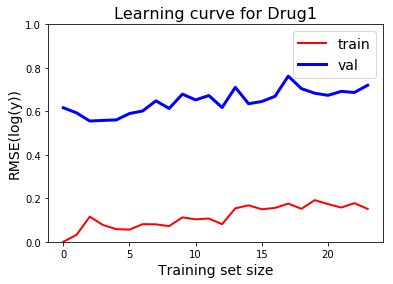

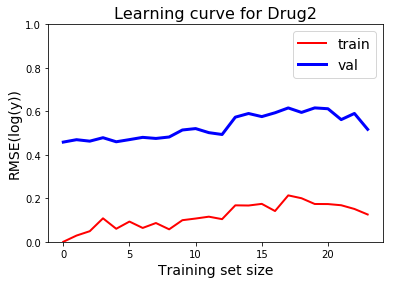

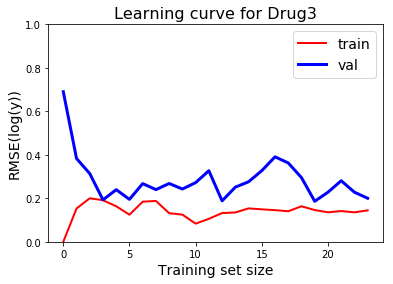

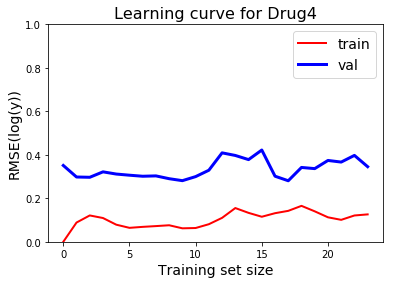

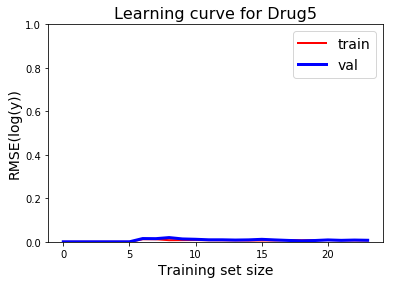

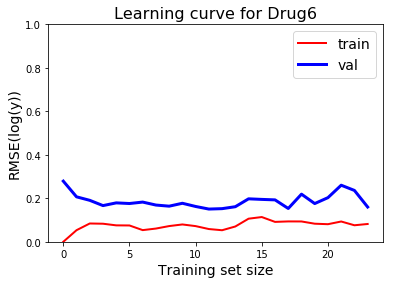

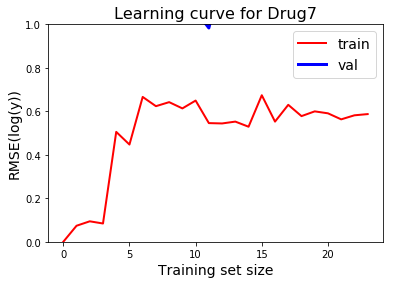

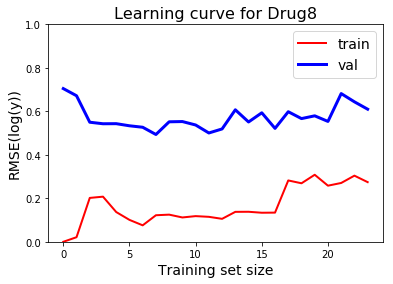

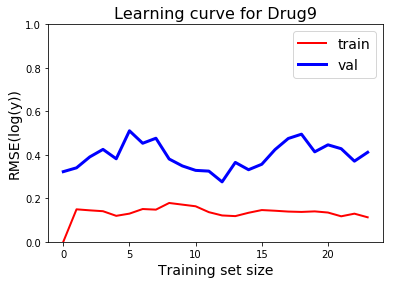

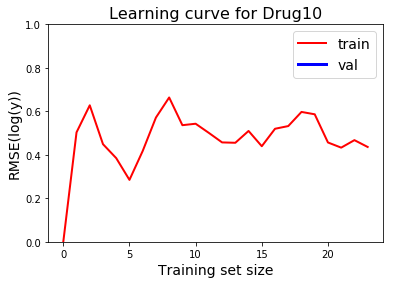

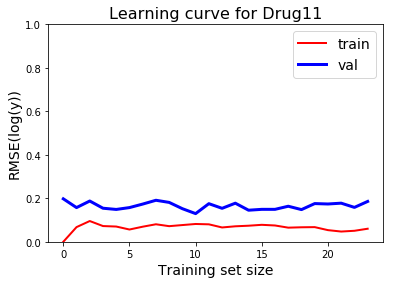

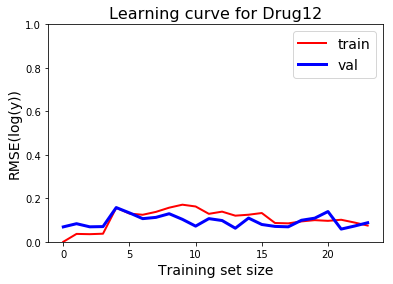

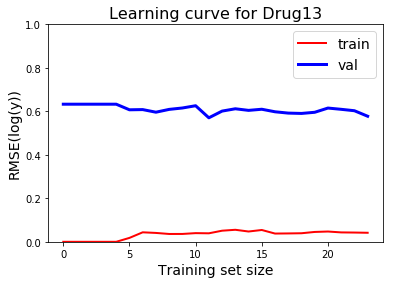

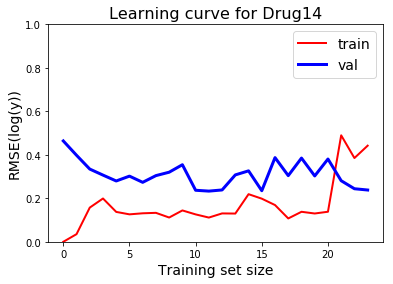

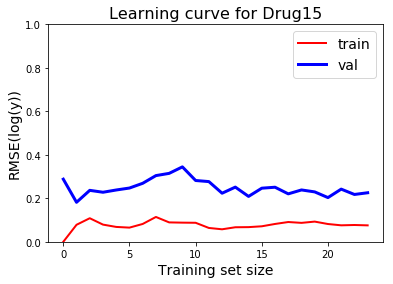

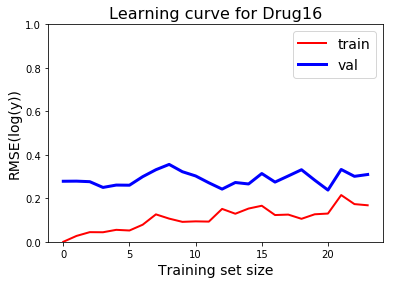

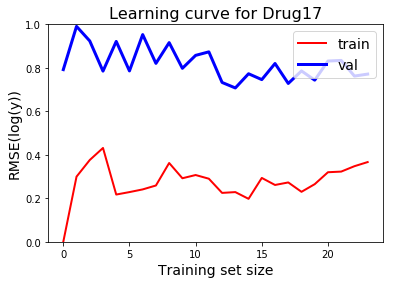

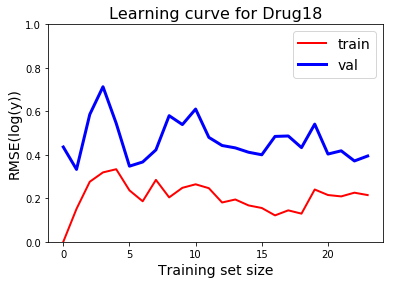

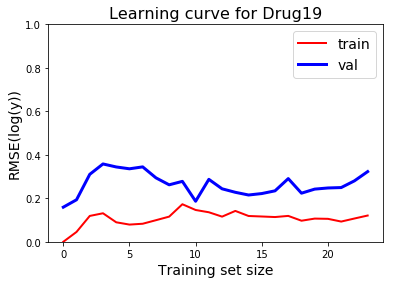

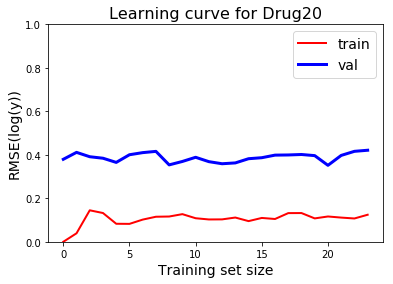

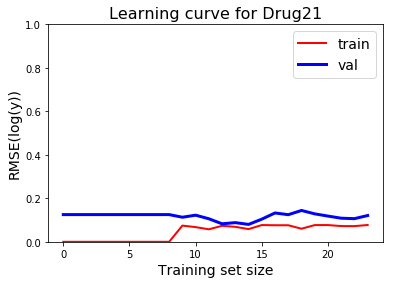

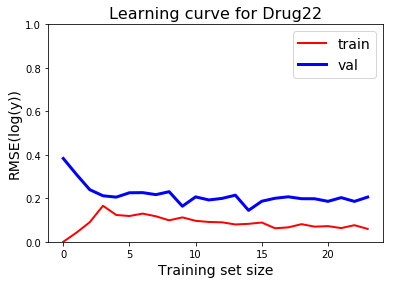

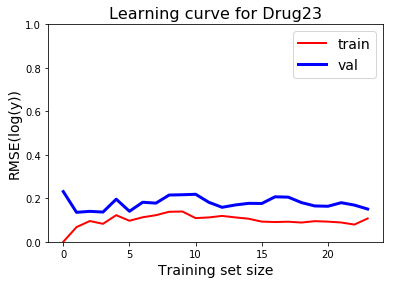

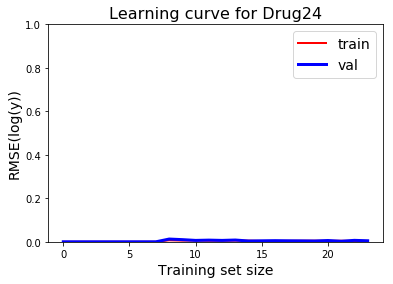

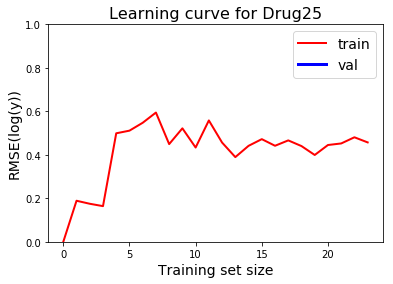

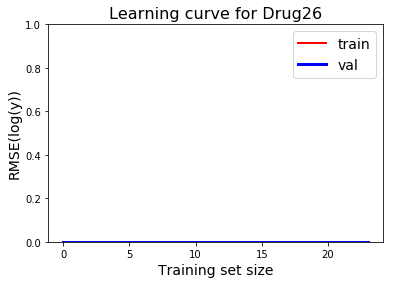

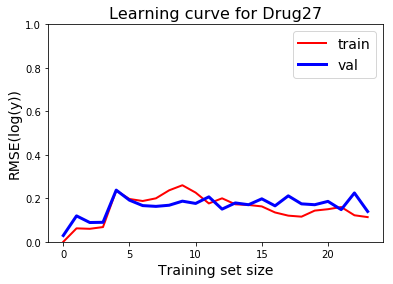

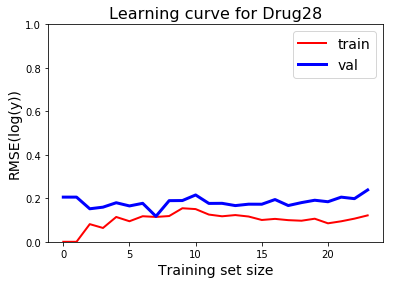

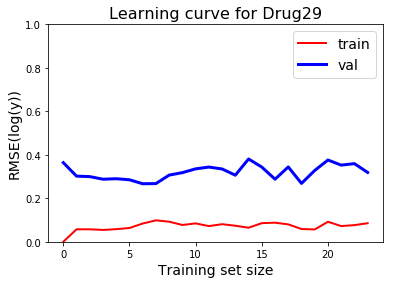

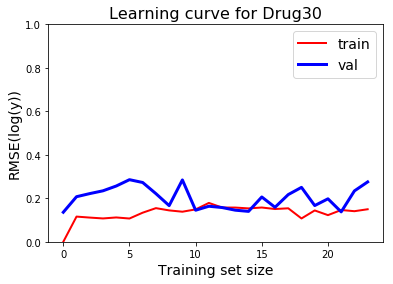

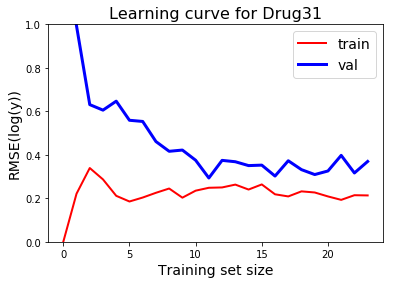

In [353]:
# perform prediction using actual response and previous model pr
new_response=all_celllines_no_fs.loc[[i for i in (all_celllines_no_fs.index) if i not in test_celllines]]
labels_w_drop=new_response.drop(['HCC1569', 'SUM229PE', 'T47DKBLUC'])
test_new_response_rf={}
for drug in list(labels_w_drop):
    label=labels_w_drop[drug]
    X=genes_train.copy()
    # select and sort celllines that has actual response values or exist in gene expression dataset and each drug 
    y=label # drug response values
    X_test=genes_test.copy()
    plot_learning_curves(rf,X,y,drug)
    rf.fit(X,y)
    test_new_response_rf[drug]=predict(rf,X_test,drug)
gene_new_response=pd.DataFrame(test_new_response_rf, 
                                columns=list(test_new_response_rf.keys()),index=list(genes_test.index))
all_celllines_new_response=gene_new_response.append(new_response)
ranked_new_response=pd.DataFrame(index=[i for i in all_celllines_new_response.index])
for drug in all_celllines_new_response:
    ranked_new_response[drug]=np.argsort(-all_celllines_new_response[drug].sort_values(ascending=False))+1
ranked_new_response.index.name='DrugAnonID'
ranked_new_response.to_csv('../scoring/dream7_drugsensitivity1_predictions_JE_new_responses_rf.csv',index=True)

# Conclusion # makes model worse

In [458]:
# SVR 
scaler=StandardScaler()
svr_reg=SVR()
X_train_scaled=scaler.fit_transform(genes_train)
X_test_scaled=scaler.fit_transform(genes_test)
X_train_t=pd.DataFrame(X_train_scaled,columns=list(genes_train),index=genes_train.index)
X_test_t=pd.DataFrame(X_test_scaled,columns=list(genes_test),index=genes_test.index)
drop_predict_svr={}
test_labels_svr={}
for drug in drug_names[:]:
    scores_gene = defaultdict(list)
    #print('Processing %s'% drug)
    # DATA CLEANING AND HOMOGENIZATION 
    # select each drug, set index to cell line and drop rows with nan
    label=labels[drug].dropna()
    X=X_train_t
    print(svr_reg)
    #corr=abs(X.corrwith(label))
   # gene_list=list(corr[corr.values>0.5].index)
    #print(len(gene_list))
    # select and sort celllines that has actual response values or exist in gene expression dataset and each drug 
    cellline=[var for var in list(X.index) if var in list(label.index)]
    cellline=sorted(cellline)
    X=X.loc[cellline] # gene expression dataset
    y=label.loc[cellline] # drug response values
    line=dropped[drug]
    # FEATURE SELECTION 
    #print(X.shape)
    #plot_learning_curves(svr_reg,X,y,drug)
    svr_reg.fit(X,y)
    test_labels_svr[drug]=predict(svr_reg,X_test_t,drug)
    X_test=X_train_t.loc[line]
    if len(line)!=0:
        pred=predict(svr_reg,X_test,drug)
        drop_predict_svr[drug]=list(zip(dropped[drug],pred))
gene_predict_svr=pd.DataFrame(test_labels_svr, columns=list(test_labels_svr.keys()),index=list(X_test_t.index))
all_celllines_svr=gene_predict_svr.append(response)
for drug in drop_predict_svr.keys():
    for i in range(len(drop_predict_svr[drug])):
        all_celllines_svr.loc[drop_predict_svr[drug][i][0],drug]=drop_predict_svr[drug][i][1]
ranked_svr=pd.DataFrame(index=[i for i in all_celllines_svr.index])
for drug in all_celllines_svr:
    ranked_svr[drug]=np.argsort(-all_celllines_svr[drug].sort_values(ascending=False))+1
ranked_svr.index.name='DrugAnonID'
ranked_svr.to_csv('../scoring/dream7_drugsensitivity1_predictions_JE_svr2.csv',index=True)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=

In [706]:
#gene_predict

In [459]:
#rna_predict
ranked_svr

,Drug1,Drug2,Drug3,Drug4,Drug5,Drug6,Drug7,Drug8,Drug9,Drug10,...,Drug22,Drug23,Drug24,Drug25,Drug26,Drug27,Drug28,Drug29,Drug30,Drug31
DrugAnonID,,,,,,,,,,,,,,,,,,,,,
184B5,33,29,19,16,8,22,25,16,31,31,...,20,6,8,31,49,14,11,30,10,10
600MPE,30,36,37,15,14,32,30,30,29,13,...,26,39,13,24,26,20,23,13,32,24
HCC2185,24,30,33,35,13,26,26,27,16,16,...,28,33,12,20,47,11,17,20,25,17
HCC3153,20,23,21,27,12,18,21,23,33,30,...,11,32,11,30,46,18,22,32,15,18
LY2,27,28,28,44,11,23,32,35,15,20,...,22,37,10,9,45,23,27,22,20,31
MCF10A,25,20,11,12,10,36,31,20,37,37,...,27,5,9,37,44,29,12,38,9,9
SKBR3,14,15,29,38,9,13,16,12,24,21,...,25,27,16,28,43,15,15,24,19,29
SUM1315MO2,16,18,17,34,16,7,18,17,35,26,...,7,36,7,29,42,28,26,29,16,26
SUM149PT,28,22,20,29,7,17,24,19,30,27,...,14,7,6,27,41,5,14,31,12,23


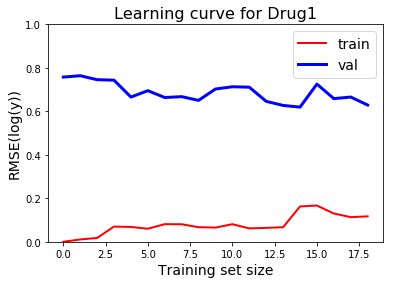

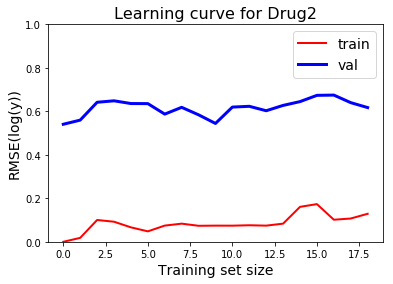

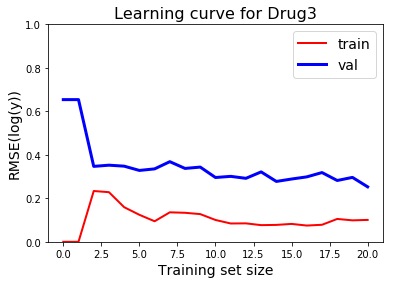

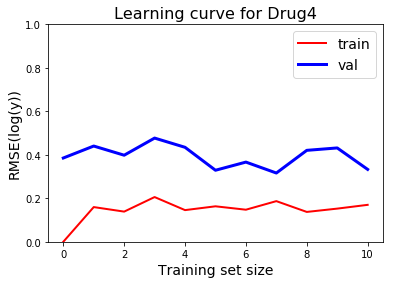

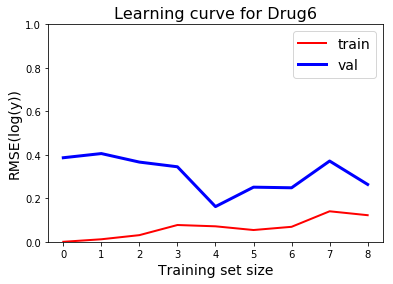

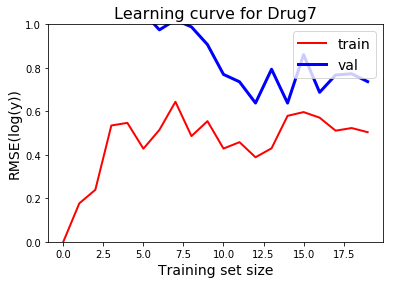

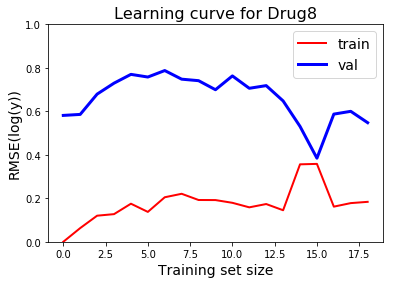

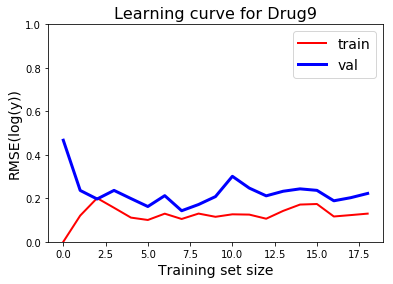

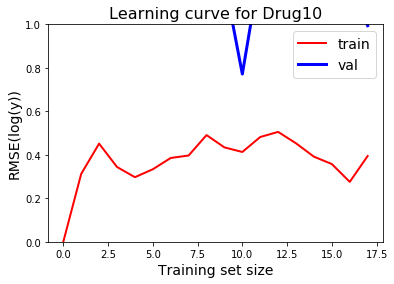

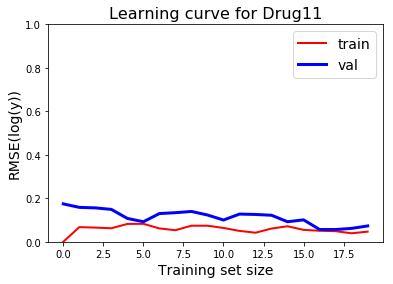

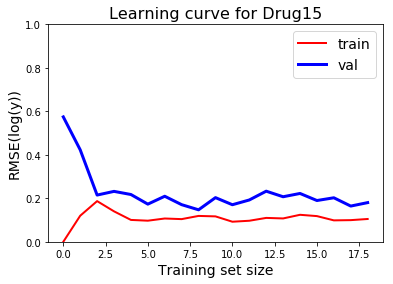

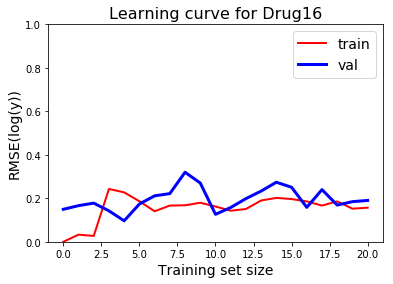

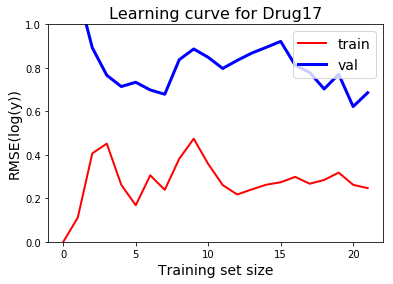

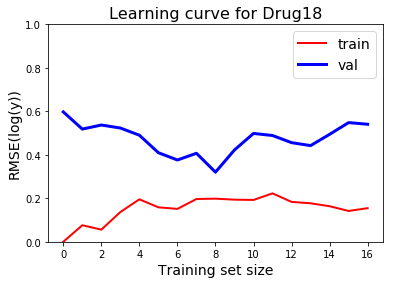

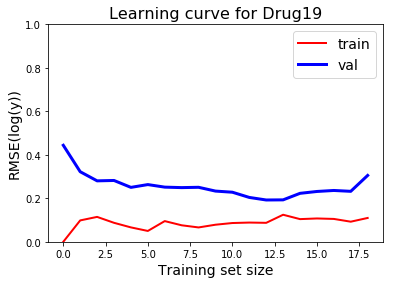

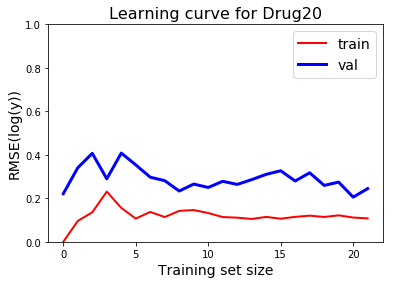

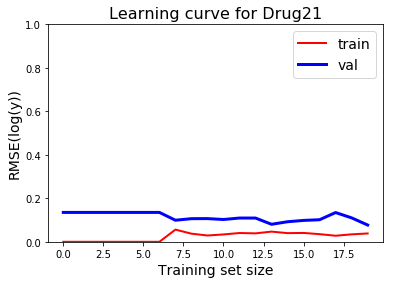

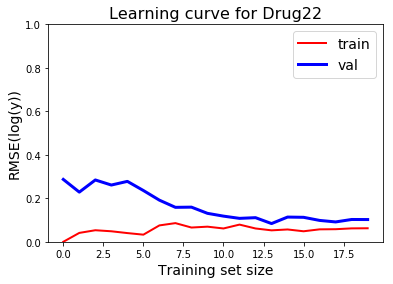

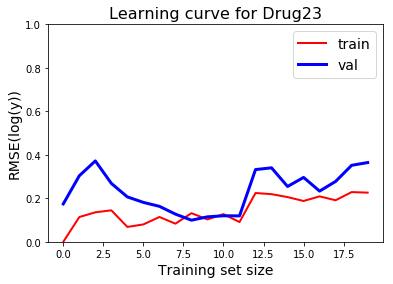

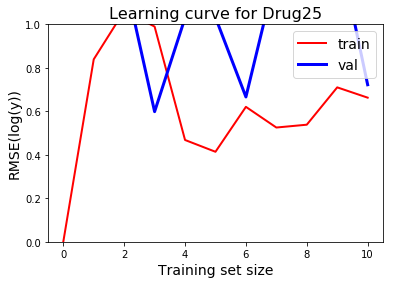

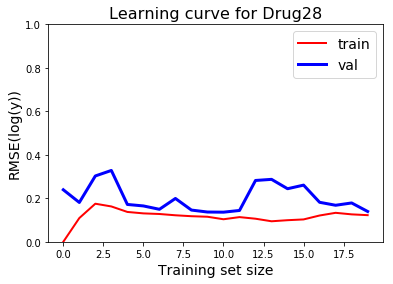

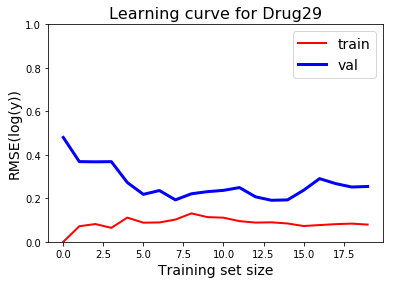

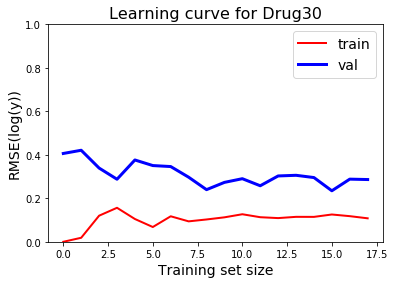

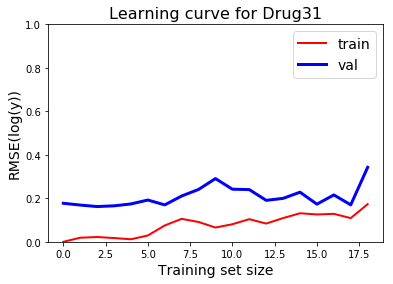

,Drug1,Drug2,Drug3,Drug4,Drug6,Drug7,Drug8,Drug9,Drug10,Drug11,...,Drug19,Drug20,Drug21,Drug22,Drug23,Drug25,Drug28,Drug29,Drug30,Drug31
184A1,4.8292,5.1097,4.4032,7.2778,5.2400,4.8837,6.9399,4.2365,5.6129,4.3270,...,6.8549,4.8362,3.6990,5.3434,4.7490,5.1547,3.9499,2.6350,6.8539,6.3851
184B5,4.5475,5.0685,4.2913,7.2362,5.1768,5.9390,6.8138,4.2703,5.8919,4.2666,...,6.8350,4.8875,3.6990,5.2273,4.5646,6.1712,4.1575,2.7319,6.8244,6.2730
21MT1,4.7173,4.6457,4.1697,7.1284,5.0637,5.4227,7.3328,4.2266,5.7896,4.4176,...,6.8564,4.8853,3.6990,5.2047,4.6895,4.5590,4.1804,2.5783,6.7767,6.4159
21NT,4.8099,5.1481,4.2274,6.9738,4.9438,5.1503,7.2711,4.3665,5.7927,4.3572,...,6.8293,4.8363,3.6990,5.3446,4.7005,5.2091,4.2478,2.5778,6.7578,6.5761
600MPE,4.9567,5.1037,4.3681,7.1005,5.1168,6.4335,6.9790,4.5702,6.8525,4.3572,...,6.7462,5.3294,3.7321,5.1263,4.4173,6.8906,4.0592,2.7810,6.6377,6.2775


In [688]:
rna_labels_g={}
consensus_features={}
for drug in drug_names[:]:
    #print('Processing %s'% drug)
    # DATA CLEANING AND HOMOGENIZATION 
    # select each drug, set index to cell line and drop rows with nan
    label=labels[drug].dropna()
    X=rna_train.copy()
    features=[key for val,key in gene_features[drug] if key in list(X)]
    consensus_features[drug]=features
    # select and sort celllines that has actual response values or exist in gene expression dataset and each drug 
    cellline=[var for var in list(X.index) if var in list(label.index)]
    cellline=sorted(cellline)
    X=X[features].loc[cellline] # gene expression dataset
    y=label.loc[cellline] # drug response values
    # FEATURE SELECTION
    #crossvalidate the scores on a number of different random splits of the data
    if X.shape[1] !=0:
        plot_learning_curves(rf,X[features],y,drug)
        rf.fit(X[features],y)
        rna_labels_g[drug]=predict(rf,rna_test[features],drug)
rna_predict_g=pd.DataFrame(rna_labels, columns=list(rna_labels.keys()),index=list(rna_test.index))
rna_predict_g.head()

In [658]:
# SVR WITH HYPERTUNING

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=0.47454011884736247, epsilon=0.10095071430640992, gamma=0.002910635913133069 
[CV]  C=0.47454011884736247, epsilon=0.10095071430640992, gamma=0.002910635913133069, total=   0.0s
[CV] C=0.47454011884736247, epsilon=0.10095071430640992, gamma=0.002910635913133069 
[CV]  C=0.47454011884736247, epsilon=0.10095071430640992, gamma=0.002910635913133069, total=   0.0s
[CV] C=0.47454011884736247, epsilon=0.10095071430640992, gamma=0.002910635913133069 
[CV]  C=0.47454011884736247, epsilon=0.10095071430640992, gamma=0.002910635913133069, total=   0.0s
[CV] C=0.6986584841970366, epsilon=0.10015601864044245, gamma=0.00020511104188433973 
[CV]  C=0.6986584841970366, epsilon=0.10015601864044245, gamma=0.00020511104188433973, total=   0.0s
[CV] C=0.6986584841970366, epsilon=0.10015601864044245, gamma=0.00020511104188433973 
[CV]  C=0.6986584841970366, epsilon=0.10015601864044245, gamma=0.00020511104188433973, total=   0.0s
[CV] C=0.6

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  C=0.15808361216819947, epsilon=0.10086617614577494, gamma=0.0015930522616241008, total=   0.0s
[CV] C=0.15808361216819947, epsilon=0.10086617614577494, gamma=0.0015930522616241008 
[CV]  C=0.15808361216819947, epsilon=0.10086617614577494, gamma=0.0015930522616241008, total=   0.0s
[CV] C=0.15808361216819947, epsilon=0.10086617614577494, gamma=0.0015930522616241008 
[CV]  C=0.15808361216819947, epsilon=0.10086617614577494, gamma=0.0015930522616241008, total=   0.0s
[CV] C=0.8080725777960455, epsilon=0.10002058449429581, gamma=0.008706020878304849 
[CV]  C=0.8080725777960455, epsilon=0.10002058449429581, gamma=0.008706020878304849, total=   0.0s
[CV] C=0.8080725777960455, epsilon=0.10002058449429581, gamma=0.008706020878304849 
[CV]  C=0.8080725777960455, epsilon=0.10002058449429581, gamma=0.008706020878304849, total=   0.0s
[CV] C=0.8080725777960455, epsilon=0.10002058449429581, gamma=0.008706020878304849 
[CV]  C=0.8080725777960455, epsilon=0.10002058449429581, gamma=0.0087060208

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.9s finished


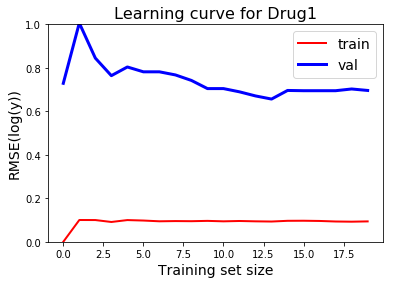

[4.80507867 4.80341727 4.8039612  4.80319788 4.80502339 4.80635847
 4.8044798  4.80366746 4.80434242 4.80389026 4.80362804 4.80414637
 4.80400987 4.80586499]


In [798]:
param_distributions = {"gamma": reciprocal(0.0001, 0.01), "C": uniform(0.1,1),"epsilon":uniform(0.1,0.001)}
rnd_search_cv = RandomizedSearchCV(svr_reg, param_distributions, n_iter=10, verbose=2, random_state=42)
for drug in drug_names[:1]:
    #print('Processing %s'% drug)
    # DATA CLEANING AND HOMOGENIZATION 
    # select each drug, set index to cell line and drop rows with nan
    label=labels[drug].dropna()
    X=X_train_t.copy()
    #corr=abs(X.corrwith(label))
   # gene_list=list(corr[corr.values>0.5].index)
    #print(len(gene_list))
    # select and sort celllines that has actual response values or exist in gene expression dataset and each drug 
    cellline=[var for var in list(X.index) if var in list(label.index)]
    cellline=sorted(cellline)
    X=X.loc[cellline] # gene expression dataset
    y=label.loc[cellline] # drug response values
    rnd_search_cv.fit(X, y)
    random_svr=rnd_search_cv.best_estimator_
    print(random_svr)
    # FEATURE SELECTION 
    #print(X.shape)
    plot_learning_curves(random_svr,X,y,drug)
    predictions=random_svr.predict(X_test_t)
    print(predictions)
    #evaluate(random_svr,X,y,'hypertuned svr')

In [708]:
#genes_train.loc[[cell for cell in c if cell in list(rna_train.index)],[key for key in r if key in list(genes_train)]]

In [705]:
#rna_train.loc[[cell for cell in c if cell in list(rna_train.index)],[key for key in r if key in list(genes_train)]]

In [709]:
#c=list(labels.Drug10[labels.Drug10.values>8].index)
#labels.Drug10[labels.Drug10.values>8]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


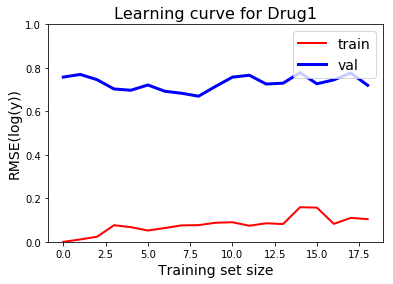

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


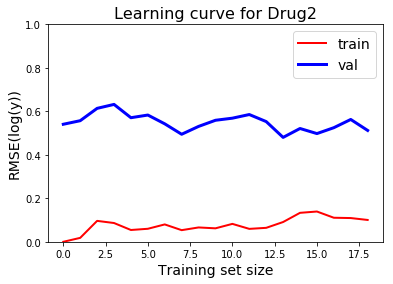

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


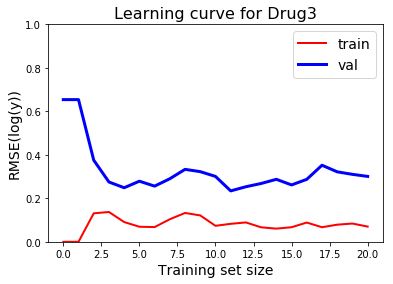

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


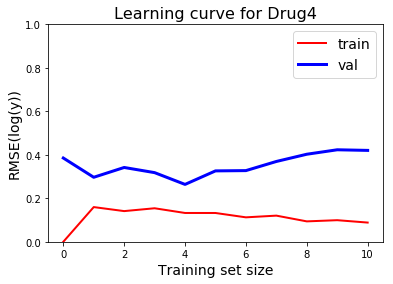

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


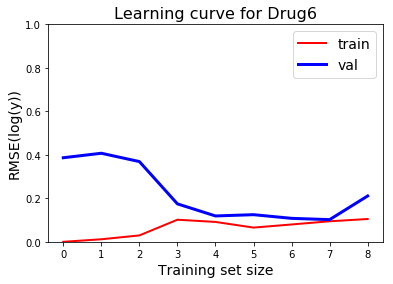

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


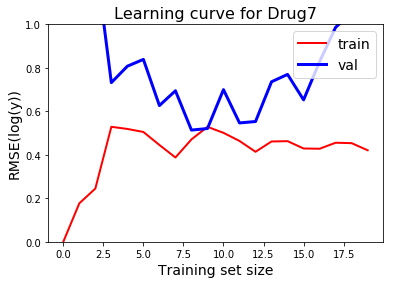

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


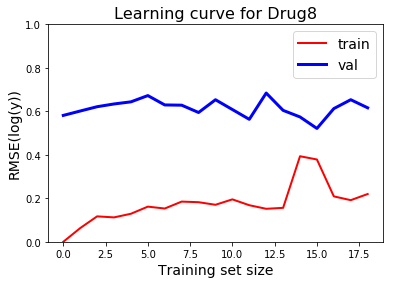

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


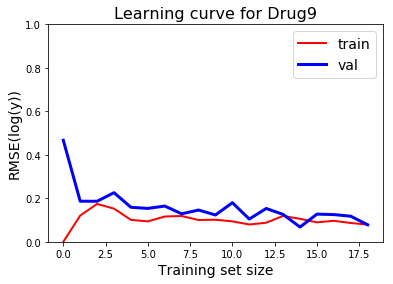

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


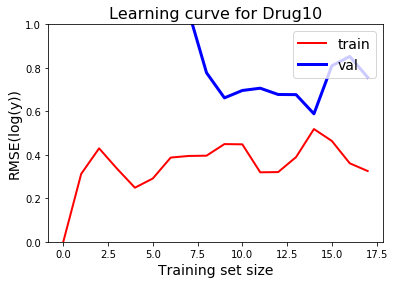

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


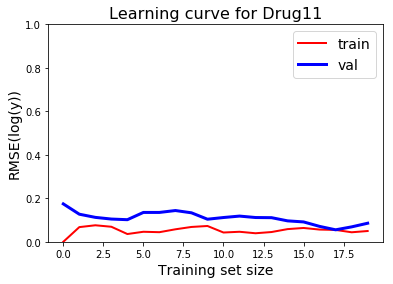

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWa

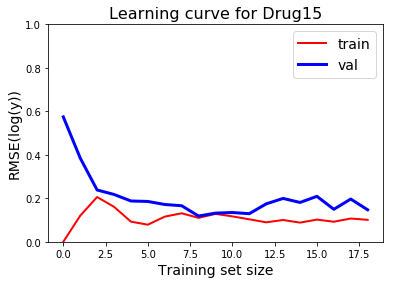

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


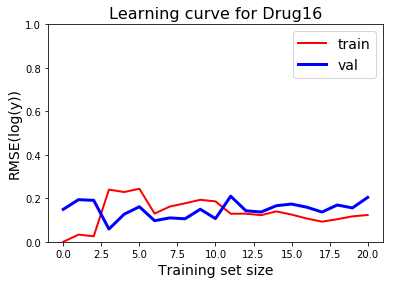

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


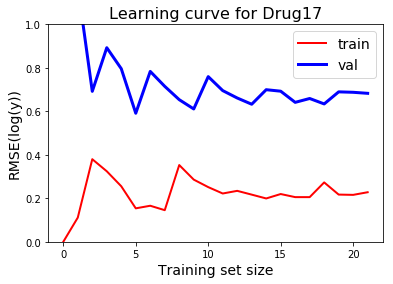

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


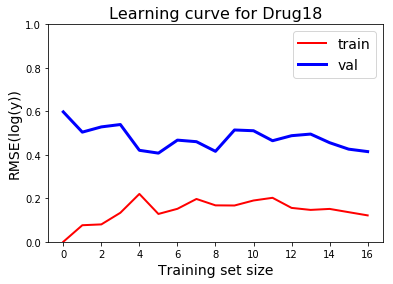

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


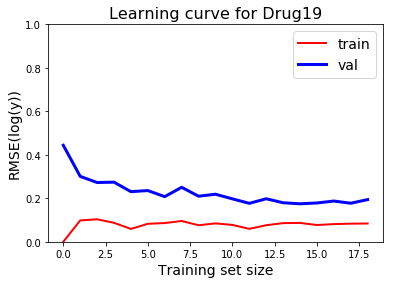

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


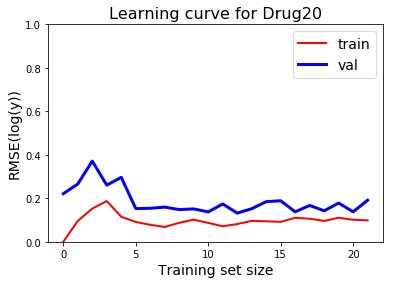

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


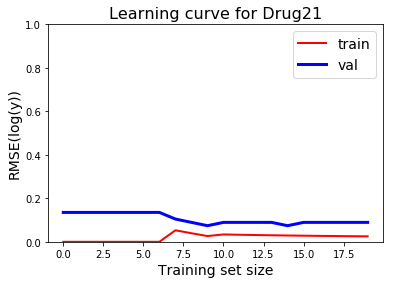

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


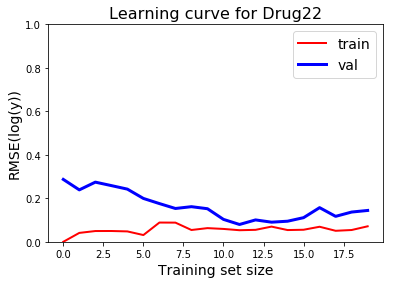

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


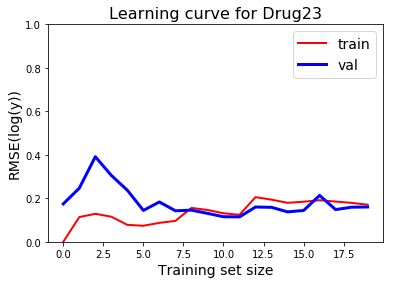

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWa

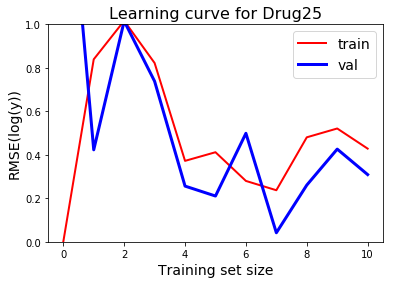

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWa

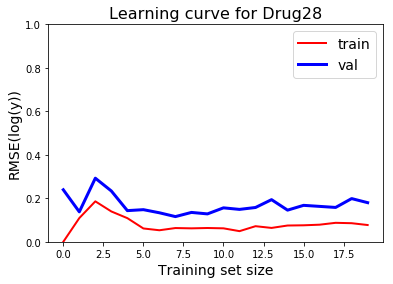

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


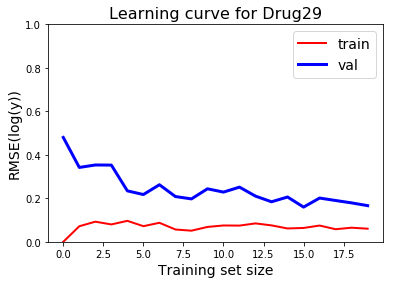

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


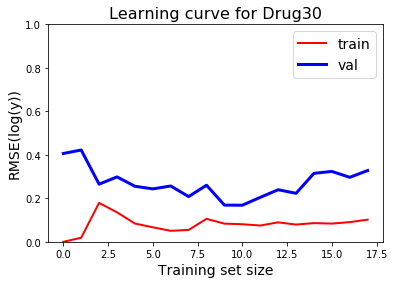

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


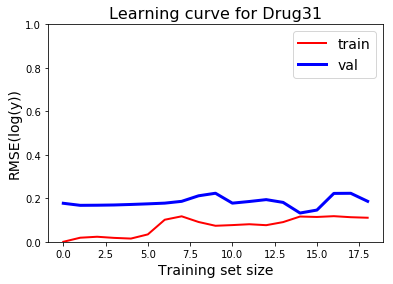

,Drug1,Drug2,Drug3,Drug4,Drug6,Drug7,Drug8,Drug9,Drug10,Drug11,...,Drug19,Drug20,Drug21,Drug22,Drug23,Drug25,Drug28,Drug29,Drug30,Drug31
184A1,4.8292,5.1097,4.4032,7.2778,5.2400,4.8837,6.9399,4.2365,5.6129,4.3270,...,6.8549,4.8362,3.6990,5.3434,4.7490,5.1547,3.9499,2.6350,6.8539,6.3851
184B5,4.5475,5.0685,4.2913,7.2362,5.1768,5.9390,6.8138,4.2703,5.8919,4.2666,...,6.8350,4.8875,3.6990,5.2273,4.5646,6.1712,4.1575,2.7319,6.8244,6.2730
21MT1,4.7173,4.6457,4.1697,7.1284,5.0637,5.4227,7.3328,4.2266,5.7896,4.4176,...,6.8564,4.8853,3.6990,5.2047,4.6895,4.5590,4.1804,2.5783,6.7767,6.4159
21NT,4.8099,5.1481,4.2274,6.9738,4.9438,5.1503,7.2711,4.3665,5.7927,4.3572,...,6.8293,4.8363,3.6990,5.3446,4.7005,5.2091,4.2478,2.5778,6.7578,6.5761
600MPE,4.9567,5.1037,4.3681,7.1005,5.1168,6.4335,6.9790,4.5702,6.8525,4.3572,...,6.7462,5.3294,3.7321,5.1263,4.4173,6.8906,4.0592,2.7810,6.6377,6.2775


In [647]:
rna_features={}
rna_labels={}
for drug in drug_names[:]:
    scores_rna = defaultdict(list)
    #print('Processing %s'% drug)
    # DATA CLEANING AND HOMOGENIZATION 
    # select each drug, set index to cell line and drop rows with nan
    label=labels[drug].dropna()
    X=rna_train.copy()
    corr=abs(X.corrwith(label))
    rna_list=list(corr[corr.values>0.5].index)
    #print(len(rna_list))
    # select and sort celllines that has actual response values or exist in gene expression dataset and each drug 
    cellline=[var for var in list(X.index) if var in list(label.index)]
    cellline=sorted(cellline)
    X=X[rna_list].loc[cellline] # gene expression dataset
    y=label.loc[cellline] # drug response values
    # FEATURE SELECTION 
    #print(X.shape)
    features=list(X) # list of genes in gene expression dataset 
    #crossvalidate the scores on a number of different random splits of the data
    rs=ShuffleSplit(10,.2)
    for train_idx, test_idx in rs.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        Y_train, Y_test = y.iloc[train_idx], y.iloc[test_idx]
        r = rf.fit(X_train, Y_train)
        acc = r2_score(Y_test, rf.predict(X_test))
        #print(sorted(train_idx))
        #print('acc',acc)
        for i in range(X.shape[1]):
            X_t = X_test.copy()
            np.random.shuffle(X_t.iloc[:, i])
            shuff_acc = r2_score(Y_test, rf.predict(X_t))
            #print('shuffle',shuff_acc)
            scores_rna[features[i]].append((acc-shuff_acc)/acc)
    feature_importance=sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores_rna.items() if np.mean(score)>0.02], reverse=True)
    rna_features[drug]=feature_importance
    best_features=[feat for score,feat in feature_importance]
    if len(best_features)>0:
        plot_learning_curves(rf,X[best_features],y,drug)
        rf.fit(X[best_features],y)
        rna_labels[drug]=predict(rf,rna_test[best_features],drug)
rna_predict=pd.DataFrame(rna_labels, columns=list(rna_labels.keys()),index=list(rna_test.index))
rna_predict.head()
    

In [779]:
svr_reg.get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [ ]:

# PREVIOUS CODE 

Processing for Drug1
printing selected features for random forest
 ['ZNF560', 'NRSN1', 'RSPH3', 'GGA3', 'SYMPK', 'THBS3', 'C17orf80', 'MGC4172', 'GINS1', 'NDUFS3', 'SERAC1', 'ZFHX4', 'AFG3L2', 'LOC723972', 'LRCH2', 'CCDC67', 'KIAA0146', 'TULP4', 'C21orf34', 'FRMD3']


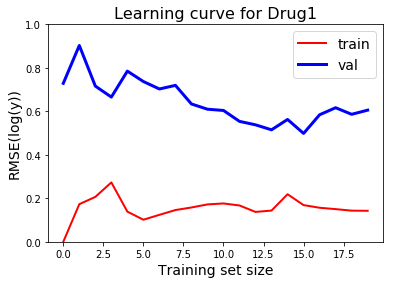

Processing for Drug2
printing selected features for random forest
 ['CDK4', 'ZFAND6', 'NACAP1', 'SNX9', 'HOMER3', 'TAF3', 'RSPH3', 'MPP6', 'TMEM181', 'PINX1', 'FLJ43505', 'GGTLA1', 'FAHD2A', 'CPNE4', 'PLXNA4A', 'VCAM1', 'STYX', 'ABTB1', 'MGAT5', 'KLHL4', 'SLC45A4', 'WEE1', 'C7orf31']


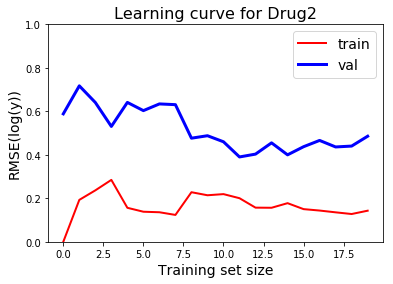

Processing for Drug3
printing selected features for random forest
 ['CAMK2N1', 'FAM84B', 'VIL2', 'SLC43A1', 'LENG4', 'DBF4', 'RSPH3', 'PSCA', 'DDX50', 'DDX21', 'SRD5A2L', 'KIAA1166', 'TOP1MT', 'EML5', 'DOPEY1', 'CTDSP1', 'C12orf11', 'NUFIP1', 'ABT1']


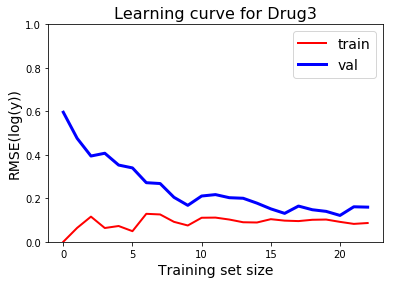

Processing for Drug4
printing selected features for random forest
 ['SMYD2', 'TMPRSS4', 'SLC35E1', 'TAF6L', 'PSMD6', 'MLL4', 'LPPR2', 'BRIP1', 'LOC100125556', 'STAP1', 'GTF3C1', 'FLOT1', 'GALNTL4', 'C6orf97', 'TCF7L2', 'GPER', 'ZCWPW2', 'SLC30A1', 'ATXN7L3', 'MTHFD2', 'FAM26D']


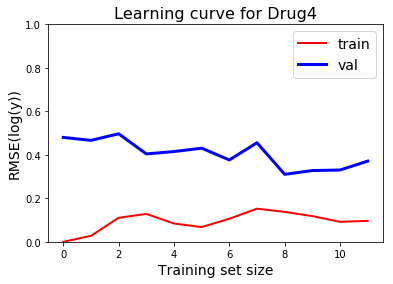

Processing for Drug5
printing selected features for random forest
 ['ZNF559', 'UGT1A10', 'TRIP13', 'SNX8', 'OXR1', 'MYEOV', 'IGKC', 'GTF2F1']


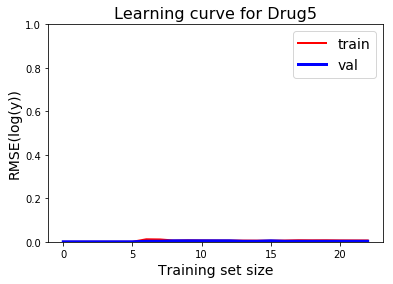

Processing for Drug6
printing selected features for random forest
 ['PRSS35', 'POLR2L', 'MEG3', 'ATP1B2', 'KCNK12', 'FLJ20581', 'NRBP1', 'PCDH21', 'AMMECR1L', 'ARF6', 'HIBADH', 'SAMD9L', 'RNF141', 'RP11-297H3.4', 'SMARCE1', 'GNAQ', 'FTMT', 'DEFB124', 'C7orf16']


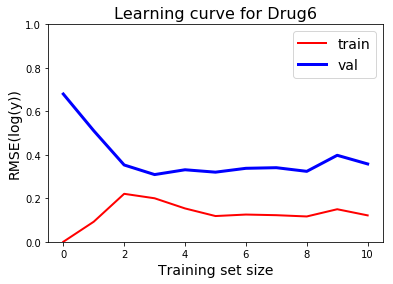

Processing for Drug7
printing selected features for random forest
 ['C12orf59', 'TUB', 'FBLN2', 'INA', 'SCAP', 'SLFN11', 'CORO6', 'NEDD8', 'GPR119', 'NUB1', 'LOC401720', 'TAS2R4', 'MGC9913', 'TMCC2', 'ZSCAN23', 'USP15', 'FLRT3', 'JPH3']


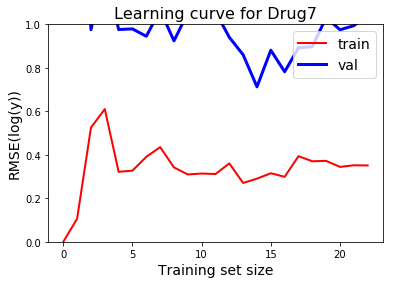

Processing for Drug8
printing selected features for random forest
 ['SEBOX', 'GSTCD', 'C1orf177', 'FCRL2', 'KIAA0892', 'NANP', 'CPSF3', 'C20orf194', 'CR1', 'DEFB128', 'ELA3A', 'SPRR4', 'LYG2', 'GPR17', 'COG2', 'UMOD', 'HECW1', 'LYVE1', 'NLGN4Y', 'HTR2A', 'SELE']


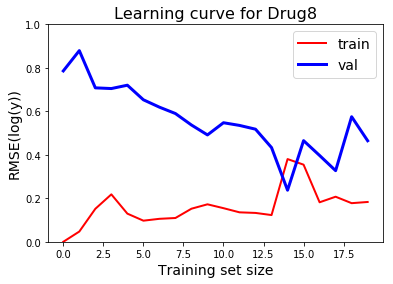

Processing for Drug9
printing selected features for random forest
 ['PGRMC1', 'C5orf24', 'C1orf190', 'PI4KAP1', 'PPP1R12C', 'ELAVL2', 'ANKMY1', 'SARS', 'OR4K14', 'ZNF710', 'FAM19A1', 'BCL3', 'TUBA1B', 'PDZRN3', 'NPM1', 'SCYL3', 'PLEKHA8']


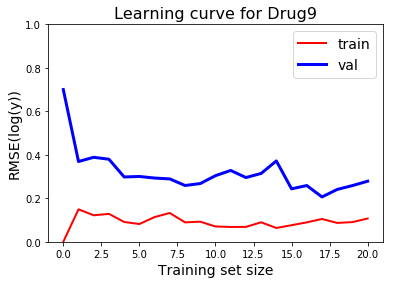

Processing for Drug10
printing selected features for random forest
 ['OR8K1', 'PSD4', 'CUL7', 'GAS6', 'LTBP2', 'GJA1', 'EIF5A2', 'ID2', 'SMAP1', 'CDC20', 'RFESD', 'PTDSS1', 'LOC339524', 'R3HDM2', 'ZNF498']


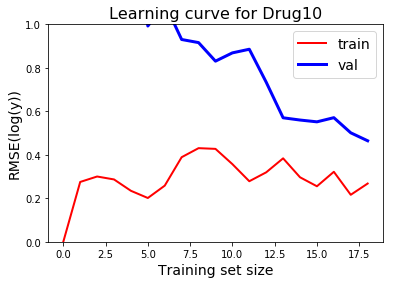

Processing for Drug11
printing selected features for random forest
 ['OR2L2', 'RNF169', 'WNT7B', 'PCOTH', 'NARS2', 'HSF4', 'LRP1B', 'SULT6B1', 'PDIA5', 'CAMK2D', 'C10orf80', 'ORAI3']


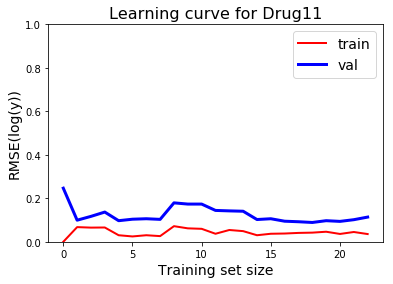

Processing for Drug12
printing selected features for random forest
 ['ZNF207', 'PSMA3', 'PLA2G3', 'OR10W1', 'NCOA5', 'EXOSC2', 'C22orf31']


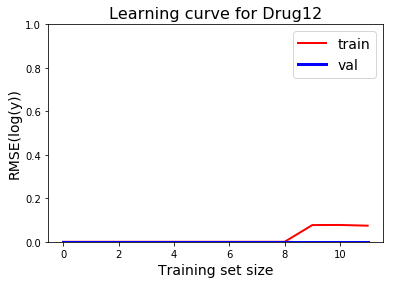

Processing for Drug13
printing selected features for random forest
 ['SNX7', 'SLC39A7', 'MYC', 'LARP2', 'GK', 'DNM3']


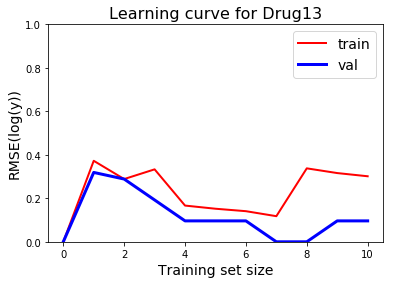

Processing for Drug14
printing selected features for random forest
 ['ZXDA', 'PAGE1', 'PPWD1', 'C7orf46', 'CLEC10A', 'KIAA1826', 'SLC14A2', 'FBXO7', 'RPS17', 'SYNGR4', 'KRT85', 'RBM12', 'NSMCE1', 'UTP20', 'IFT20', 'TIMP2']


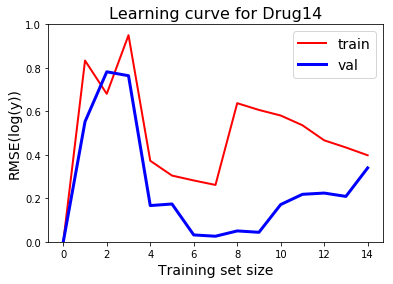

Processing for Drug15
printing selected features for random forest
 ['C1orf166', 'PDCD4', 'IFNA8', 'STK17A', 'SLC47A1', 'TLX3', 'TMEM16E', 'GPC1', 'RPL22L1', 'COQ2', 'PCMTD1', 'WDR70', 'UGT1A9', 'PELO', 'FBXO25', 'MYO6', 'PIP4K2B', 'C20orf23', 'SBK1', 'DLG3']


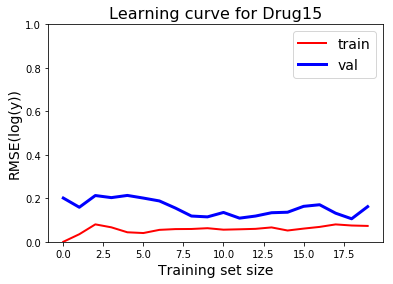

Processing for Drug16
printing selected features for random forest
 ['VAV1', 'GP1BA', 'KIAA0831', 'KRT83', 'NUDT1', 'IL1F5', 'GRASP', 'JAK3', 'OPTC', 'NF1', 'C21orf129', 'FAIM2', 'IQSEC2', 'TMEM112B', 'STX2', 'FAM80B', 'UGT1A1', 'BTK', 'LOC145757', 'C21orf56', 'LGALS12', 'RASL10A', 'MCM3AP']


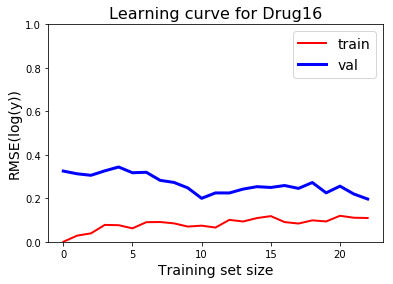

Processing for Drug17
printing selected features for random forest
 ['MAGEB18', 'MTSS1', 'VPS18', 'TESSP5', 'HRSP12', 'LOC348801', 'CHST14', 'FLJ20699', 'RAPGEFL1', 'SIX6', 'CYP4A11', 'JARID2', 'KCNK16', 'ALLC', 'RAB3C']


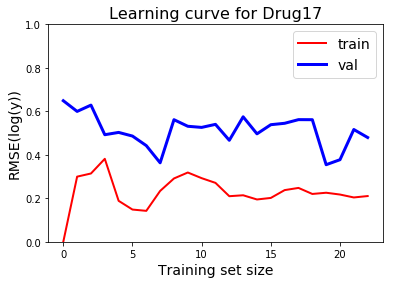

Processing for Drug18
printing selected features for random forest
 ['RP4-692D3.1', 'MGC52110', 'TNRC6C', 'TINF2', 'TCIRG1', 'ELN', 'PPIF', 'HSPA5', 'CEP57', 'USP14', 'FKBP1A', 'RPS16', 'TBC1D9', 'NUDT12', 'FAM80B', 'GEMIN8', 'AMOTL1', 'NR2F2', 'RBJ', 'TEX10']


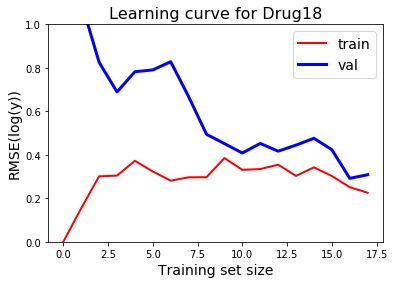

Processing for Drug19
printing selected features for random forest
 ['LOC100125556', 'MYEOV2', 'PFKFB1', 'PRPSAP1', 'FGFBP1', 'B4GALT1', 'INTS2', 'LOC441108', 'CXCR6', 'TGM1', 'CECR1', 'EDC4', 'SLC35C1', 'FLJ35767', 'KIAA1666']


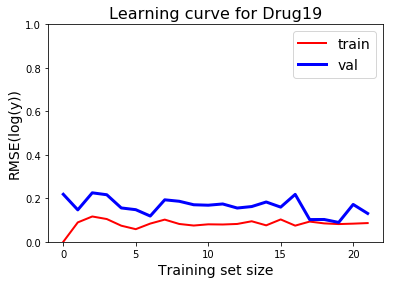

Processing for Drug20
printing selected features for random forest
 ['S100A1', 'GOLGA3', 'CMTM4', 'C15orf42', 'STGC3', 'ZNF573', 'TOP2A', 'ANKRD30A', 'FAM84B', 'CRLF3', 'RCCD1', 'MRPL16', 'EBPL', 'S100A8', 'MYST2', 'THNSL1', 'MEX3D', 'MGC26718', 'UST', 'LRRC8E']


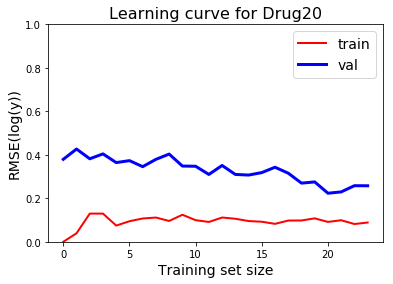

Processing for Drug21
printing selected features for random forest
 ['SAG', 'TBC1D13', 'ZNF502', 'ASB14', 'NSMCE4A', 'LOC389207', 'C14orf166B', 'IPPK', 'KIAA1727']


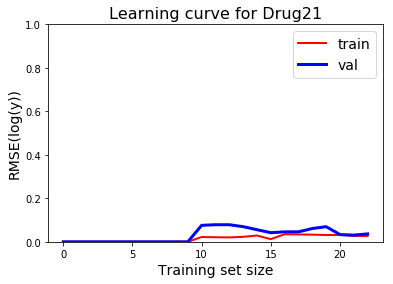

Processing for Drug22
printing selected features for random forest
 ['HORMAD1', 'HLTF', 'TPM2', 'ST8SIA1', 'THBS3', 'CYYR1', 'PHF6', 'CDKN1A', 'ARSB', 'SLC25A14', 'WNT5B', 'NPAL1', 'IL1RAPL2', 'HIPK3', 'C1S', 'UBE2A', 'ADAL']


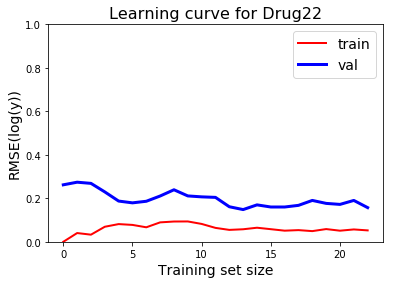

Processing for Drug23
printing selected features for random forest
 ['MGC14376', 'NBPF20', 'TMEM173', 'DIP2C', 'TRIM7', 'PLAGL1', 'ZKSCAN2', 'RP11-679B17.1', 'C10orf62', 'NBPF1', 'KCTD13', 'EYA2', 'DMBT1', 'SPRR2A', 'ACOT11', 'TNFSF9', 'ELA3B', 'NWD1', 'C6orf142']


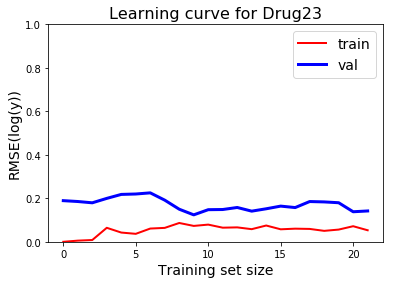

Processing for Drug24
printing selected features for random forest
 ['TCL1B', 'TCEB3', 'SPERT', 'PPIH', 'OR7E91P', 'GDPD2', 'ATOH8', 'APBA1']


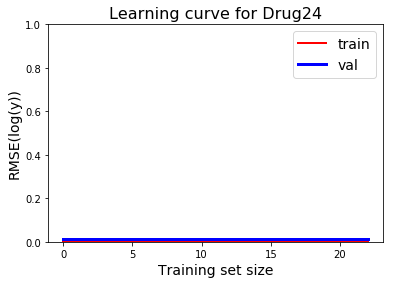

Processing for Drug25
printing selected features for random forest
 ['MTRF1L', 'MS4A8B', 'RTN3', 'NDUFS8', 'RCOR2', 'COPG', 'MET', 'TRPT1', 'ZC3H6', 'DHX58']


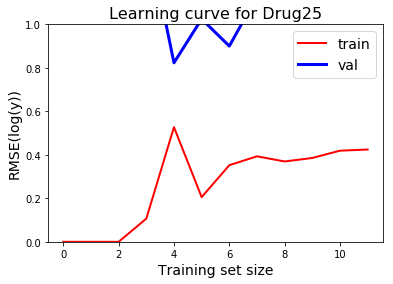

Processing for Drug27
printing selected features for random forest
 ['TPCN2', 'TCTN3', 'SP4', 'SAFB2', 'PCDH1', 'NXF1', 'NARG1', 'POLG2', 'GPR110']


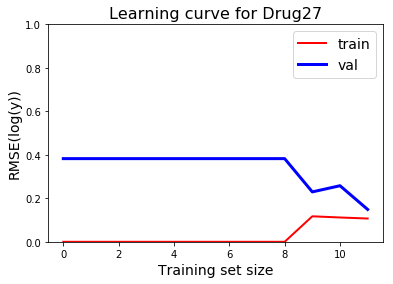

Processing for Drug28
printing selected features for random forest
 ['CITED4', 'TJP2', 'ZNF514', 'ZNF182', 'JRK', 'FUT8', 'PELI2', 'ADPRHL2', 'ZFP41', 'FADS1']


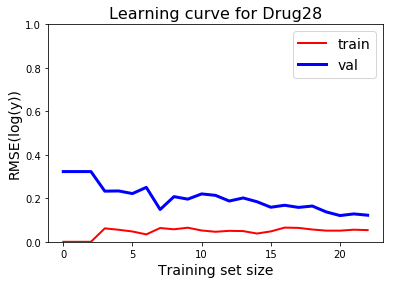

Processing for Drug29
printing selected features for random forest
 ['PLSCR3', 'MKNK2', 'DIP', 'RXRA', 'TMEM127', 'GARNL3', 'MYPN', 'CETN2', 'ZFP14', 'ACSS1', 'NDUFA3', 'SERPINE2', 'PRRG2', 'IQCE', 'TRAPPC6A', 'MARCKSL1']


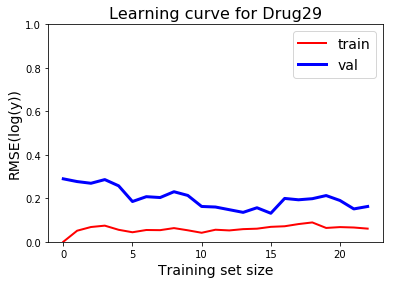

Processing for Drug30
printing selected features for random forest
 ['MRPL21', 'IL13', 'B4GALT1', 'SAPS3', 'TBC1D15', 'FKHL18', 'DULLARD', 'UBXD4', 'ZRSR1', 'CEBPD', 'LRRK2', 'CCDC50', 'HAVCR1', 'ADI1', 'ENPP5', 'KRTAP10-8', 'PABPC3', 'AICDA', 'HOXA3']


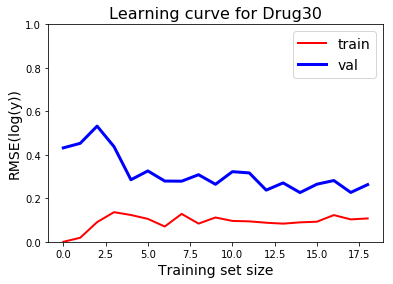

Processing for Drug31
printing selected features for random forest
 ['B4GALT1', 'SAPS3', 'AK1', 'CHMP5', 'NFIL3', 'HERC2', 'NUDT2', 'WHDC1L1', 'EPYC', 'LYZL6', 'FLJ45256', 'NPHP1', 'C10orf97', 'ATIC', 'APRT', 'LOC285733', 'ARPP-21']


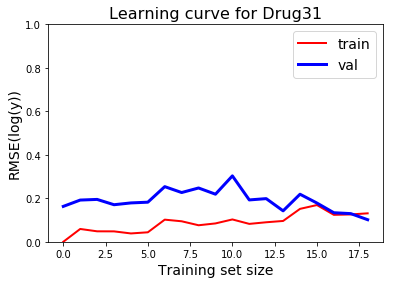

In [215]:
# FEATURE SELECTION AND EVALUATION STRATEGY using RF 
impurity_features={}
for drug in drug_names[:]:
    print('Processing for',drug)
    # DATA CLEANING AND HOMOGENIZATION 
    
    # select each drug, set index to cell line and drop rows with nan
    label=labels[drug].dropna()
    X=genes_train.copy()
    corr=abs(X.corrwith(label))
    gene_list=list(corr[corr.values>0.5].index)
    #print(len(gene_list))
    # select and sort celllines that has actual response values or exist in gene expression dataset and each drug 
    cellline=[var for var in list(X.index) if var in list(label.index)]
    cellline=sorted(cellline)
    X=X[gene_list].loc[cellline] # gene expression dataset
    y=label.loc[cellline] # drug response values
    #print('actual labels by cell line\n',label)
    # alternatively if response values have been imputed the above line changes to  
    #label=labels[['CellLine',drug]].set_index('CellLine') 
    
    # FEATURE SELECTION 
    features=list(X) # list of genes in gene expression dataset 
    
    # split data 
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    # fit(if using a model) or perform feature-response correlation first 
    rf.fit(X,y) # random forest method. see parameters definition above
    #rf.fit(X_train,y_train) # random forest method. see parameters definition above
    
    # determine and rank features (descending order) based on their importance(algorithm specific)
    rf_importance=sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_),features), reverse=True) 
    
    # select features above certain threshhold(need to be manually determined)
    feature_coeff=[(feature,coeff) for coeff,feature in rf_importance if coeff >0.01] 
    impurity_features[drug]=feature_coeff
    # get important features 
    best_features=[feature for feature,val in feature_coeff] 
    print('printing selected features for random forest\n',best_features)
    
    # EVALUATE PREDICTION ERROR AND ACCURACY
    #B=X[best_features]
    #rf.fit(B,y_test)
    B=X_test[best_features]
    #plot_learning_curves(rf,X[best_features],y,drug)
    #rf.fit(B,y_test)
    

In [223]:
# search for best hyperparameters by tuning the following parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start =2 , stop = 10, num = 5)]
#n_estimators = [int(x) for x in np.linspace(start =2 , stop = 8, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
#max_depth = [int(x) for x in np.linspace(50, 90, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [220]:
impurity_features

{'Drug1': [('ZNF560', 0.1013),
  ('NRSN1', 0.0815),
  ('RSPH3', 0.081),
  ('GGA3', 0.0789),
  ('SYMPK', 0.072),
  ('THBS3', 0.0695),
  ('C17orf80', 0.0622),
  ('MGC4172', 0.0514),
  ('GINS1', 0.0514),
  ('NDUFS3', 0.0437),
  ('SERAC1', 0.0394),
  ('ZFHX4', 0.0381),
  ('AFG3L2', 0.0332),
  ('LOC723972', 0.029),
  ('LRCH2', 0.0278),
  ('CCDC67', 0.0194),
  ('KIAA0146', 0.0133),
  ('TULP4', 0.0123),
  ('C21orf34', 0.0109),
  ('FRMD3', 0.0104)],
 'Drug10': [('OR8K1', 0.1526),
  ('PSD4', 0.0827),
  ('CUL7', 0.0822),
  ('GAS6', 0.0815),
  ('LTBP2', 0.0802),
  ('GJA1', 0.0798),
  ('EIF5A2', 0.0779),
  ('ID2', 0.0711),
  ('SMAP1', 0.0709),
  ('CDC20', 0.0234),
  ('RFESD', 0.0164),
  ('PTDSS1', 0.015),
  ('LOC339524', 0.0139),
  ('R3HDM2', 0.0126),
  ('ZNF498', 0.0114)],
 'Drug11': [('OR2L2', 0.2147),
  ('RNF169', 0.1875),
  ('WNT7B', 0.1),
  ('PCOTH', 0.1),
  ('NARS2', 0.1),
  ('HSF4', 0.0874),
  ('LRP1B', 0.0868),
  ('SULT6B1', 0.071),
  ('PDIA5', 0.0143),
  ('CAMK2D', 0.0132),
  ('C10orf80',

In [ ]:
# First create the base model to tune
from sklearn.model_selection import RandomizedSearchCV
rf_rand = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1) # model that tunes the hyperparameters
for drug in drug_names[:2]:
    print(drug)
    label=labels[['CellLine',drug]].dropna().set_index('CellLine')
    # select and sort celllines that has actual response values
    cellline=[var for var in cell_type if var in list(label.T)]
    cellline=sorted(cellline)
    X=genes.copy() # fresh copy of genes
    X=X.loc[cellline] # select celllines with corresponding response values
    y=label.loc[cellline].values.ravel()# select labels with non NAN values
    attributes=list(X) # features(genes)
    # Feature selection with no hypertuning
    rf.fit(X,y) # fit the data first
    rf_base=sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_),attributes), 
            reverse=True) # determine and rank features based on their importance 
    vars_base=[(feature,val) for val,feature in rf_base if val >0.02] # select features above certain threshhold
    base_vars=[feature for feature,val in vars_base] # get important features names
    # FIT AND EVALUATE WITH SELECTED FEATURES 
    B=X[base_vars]
    print('Nonhypertuned features are : %s'%sorted(list(B)))
    # FEATURE SELECTION WITH CROSS VALIDATED HYPERPARAMETERS
    rf_rand.fit(X,y)
    d=rf_rand.best_params_
    rf_mod=RandomForestRegressor(max_depth=d['max_depth'],n_estimators=d['n_estimators'],
                                 random_state=42,bootstrap=d['bootstrap'],
                                 max_features=d['max_features'])
                                #min_samples_leaf=d['min_samples_leaf']) # create model with best features 
    rf_mod.fit(X,y) 
    rf_random=sorted(zip(map(lambda x: round(x, 4), rf_mod.feature_importances_),attributes), 
            reverse=True) # select 
    vars_random=[(feature,val) for val,feature in rf_random if val >0.02]
    random_vars=[feature for feature,val in vars_random] # get important features 
    R=X[random_vars]
    print('Hypertuned features are :    %s\n' %sorted(list(R)))
    rf.fit(B,y)
    base_accuracy=evaluate(rf,B,y,'Random forest')
    rf.fit(R,y)
    random_accuracy=evaluate(rf,R,y,'Random forest with hypertuning')
    combo=list(set(base_vars+random_vars))
    C=X[combo]
    rf.fit(C,y)
    combo_accuracy=evaluate(rf,C,y,'Combo')
    #combo_accuracy_mod=evaluate(rf_mod,C,y)
    print('  Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
    print('  Improvement of {:0.2f}%.'.format( 100 * (combo_accuracy - base_accuracy) / base_accuracy))
    print('  Improvement of {:0.2f}%.'.format( 100 * (combo_accuracy - random_accuracy) / random_accuracy))
    print('\n')
    #print('There are %s important features for %s:\n%s\n' %(len(important_vars),drug,important_vars))

In [226]:
# linear regression feature selection
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, RidgeCV, LassoCV)
from sklearn.preprocessing import MinMaxScaler
lr = LinearRegression(normalize=True)
#lasso=Lasso(alpha=0.05)
ridge=Ridge(alpha=0.05,normalize=True)
rfe = RFE(lr, n_features_to_select=50, verbose =3 )
alphas = 10**np.linspace(10,-2,100)*0.5
for drug in drug_names[:5]:
    print(drug)
    label=labels[['CellLine',drug]].dropna().set_index('CellLine')
    cellline=[var for var in cell_type if var in list(label.T)]
    cellline=sorted(cellline)
    X=genes.copy()
    X=X.loc[cellline]
    y=label.loc[cellline].values.ravel()
    attributes=list(X)
    #lasso.fit(X,y)
    #ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)
    #lasso_importance=sorted(zip(map(lambda x: round(x, 4), abs(lasso.coef_)),attributes), 
           # reverse=True)
    #vars_val=[(feature,val) for val,feature in lasso_importance if val >0.002]
    #important_vars=[feature for feature,val in vars_val] # get important features 
    ridge.fit(X,y)
    ridge_importance=sorted(zip(map(lambda x: round(x, 4), abs(ridge.coef_)),attributes),reverse=True)
    v_val=[(feature,val) for val,feature in ridge_importance if val >0.001]
    import_vars=[feature for feature,val in v_val] # get important features 
    print('ridge features no CV:\n',import_vars)
    #ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
    #ridgecv.fit(X,y)
    #print(ridgecv.alpha_)
   # ridge_opt_alpha=Ridge(alpha=ridgecv.alpha_, normalize=True)
   # ridge_opt_alpha.fit(X,y)
   # ridge_opt_importance=sorted(zip(map(lambda x: round(x, 4), abs(ridge_opt_alpha.coef_)),attributes),reverse=True)
   # v_val=[(feature,val) for val,feature in ridge_opt_importance if val >0.002]
    #import_vars=[feature for feature,val in v_val] # get important features 
    #print('ridge features CV:\n',import_vars)
    #X=X[important_vars]
    #if len(X)==0:continue
    #lr.fit(X,y)
    #base_accuracy=evaluate(lr,X,y)
    #print('\n')
    #print('There are %s important features for %s:\n%s\n' %(len(important_vars),drug,important_vars))

Drug1
ridge features no CV:
 ['NACAP1', 'tcag7.1136', 'FAM128B', 'SERAC1', 'OMD', 'G30', 'CLEC4A', 'CD53', 'ASB17', 'TXNRD2', 'TRIM50', 'RGSL1', 'COL10A1', 'ALX3', 'AGXT2', 'ABCB5', 'PKNOX1', 'NAALAD2', 'MFSD4', 'ITK', 'GFRAL', 'URP2', 'TLL2', 'SNX3', 'LY86', 'LOC360030', 'KCNQ1DN', 'IAPP', 'GLULD1', 'GABPB2', 'FLG', 'FAM86C', 'C21orf49', 'ZFYVE26', 'TXK', 'SYF2', 'PNLIPRP1', 'OR5B17', 'OGN', 'LOC728957', 'LCE5A', 'IGKV1-5', 'HSFY1', 'FBXO34', 'FAM39E', 'FAM39B', 'CLEC4C', 'C9orf138', 'APOBEC3A', 'AKAP14', 'ZNF536', 'VENTXP1', 'UBE2D3', 'THBS2', 'SYMPK', 'SCRN2', 'SAP30', 'PLSCR5', 'PF4', 'MYL1', 'LOC729423', 'LAMA1', 'KCNH8', 'HOMER3', 'GPR173', 'GLRA3', 'FLJ20294', 'FAM44A', 'CXCL6', 'CHCHD6', 'CD164L2', 'CAPN10', 'C4orf17', 'C20orf58', 'BTG4', 'BHMT', 'ARMCX4', 'AOAH', 'ACOT12', 'ABTB1', 'ZPBP', 'ZNF335', 'TCTE3', 'TBCC', 'TBCA', 'T1560', 'STYX', 'SH2D1A', 'SFRS4', 'SCN9A', 'RTP2', 'RGS8', 'RFXDC1', 'RFTN2', 'PAPLN', 'OR5T1', 'NUDT3', 'LYRM2', 'LRRC19', 'LRCH2', 'LENG1', 'KRTAP6-1',

In [355]:
correlated_genes

{}

In [ ]:
# univariate feature selection using random forest and cross validation 
from sklearn.model_selection import cross_val_score, ShuffleSplit
rf = RandomForestRegressor(n_estimators=20, max_depth=100)
for drug in drug_names[:4]:
    label=labels[['CellLine',drug]].dropna().set_index('CellLine')
    cellline=[var for var in cell_type if var in list(label.T)]
    cellline=sorted(cellline)
    X=genes.copy()
    X=X.loc[cellline]
    y=label.loc[cellline]
    scores=[]
    attributes=list(X)
    for i in range(X.shape[1]):
     score = cross_val_score(rf, X.iloc[:, i:i+1], y.values.ravel(), scoring="r2",
                              cv=ShuffleSplit(len(X), 3, .3))
     scores.append((round(np.mean(score), 3), attributes[i]))
    print(drug)
    print(sorted(scores, reverse=True))

In [ ]:
from sklearn.datasets import load_boston
boston=load_boston()
X=boston['data']
names=boston['feature_names']
type(X)

In [ ]:
#for drug in drug_names:
    #label=labels[['CellLine',drug]].dropna().set_index('CellLine')
    #label=label.sort_values(by=drug,ascending=False)
    #plt.figure(figsize=(10,6))
    #sns.heatmap(label,cmap="RdBu_r",annot=True,robust=True)
#    plt.show()

#drug10=[('ALDH3B2', 0.0828), ('ZNRF2', 0.0826), ('TBC1D17', 0.082), ('HINT3', 0.0797), ('ACOT2', 0.0796), ('TIAM2', 0.0781), ('CLIC1', 0.076), ('GPR156', 0.0759), ('ATPIF1', 0.0747), ('LPAL2', 0.0744),('OR8K1', 0.7743), ('CPA1', 0.1303), ('LYZL4', 0.0548)]
#g=[]
#drug10=[('TBC1D22B', 0.1576), ('TRIM56', 0.0857), ('ICHTHYIN', 0.0852), ('UNQ6411', 0.0819), ('GPR110', 0.0816), ('TIMM22', 0.078), ('PPP1R1B', 0.0756), ('OR8K1', 0.073), ('UGT2B10', 0.0619)]
#for a,b in drug10:
 #   g.append(a)
#cellline=[var for var in cell_type if var in list(label[label.values>8].T)]
#cellline=sorted(cellline)
#for var in cellline:
#    print(label.loc[var],gene.loc[var,g])
#print(label.index)

In [ ]:
label=labels[['CellLine','Drug7']].dropna().set_index('CellLine')
label=label[label.Drug7>6.5].sort_values(by='Drug7',ascending=False)
print(label)
cellline=[var for var in list(label.T) if var in cell_type]
print(cellline)
#cellline=sorted(cellline)
gene=genes.copy()
gene.loc[cellline,[col for col in gene if col.startswith('ALDH')]]

In [ ]:
gene.describe()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
# perform regression with cross validation 
# grab orderd cellLines from attributes dataset and label
drug_names=[name for name in response.columns if name !='CellLine']
for drug in drug_names:
    label=labels[['CellLine',drug]].dropna().set_index('CellLine')
    cellline=[var for var in cell_type if var in list(label.T)]
    cellline=sorted(cellline)
    X=genes.copy()
    X=X.loc[cellline]
    y=label.loc[cellline]
    attributes=list(X)
    rf=DecisionTreeRegressor()
    rf.fit(X,y.values.ravel()) 
    rf_importance=sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_),attributes), 
            reverse=True)
    important_vars=[(feature,val) for val ,feature in rf_importance if val >0.05]
    print('There are %s important features for %s:\n%s\n' %(len(important_vars),drug,important_vars))

In [ ]:
# IMPUTE USING MICE AND PLOT A HEATMAP OF IMPUTED DATA 

In [ ]:
#from fancyimpute import MICE
#mice=MICE(verbose=False)
#impute=pd.DataFrame(mice.complete(response.iloc[:,1:]),\
 #                   index=response.CellLine,columns=drug_names)
#plt.figure(figsize=(20,8))
#sns.heatmap(impute,cmap="RdBu_r",annot=False,square=True,robust=True)
#plt.show()


In [ ]:
# HEAT MAP FOR KNN IMPUTATION 
#from fancyimpute import KNN
#knn=KNN(k=3)
#impute=pd.DataFrame(knn.complete(response.iloc[:,1:]),\
 #                   index=response.CellLine,columns=drug_names)

#plt.figure(figsize=(20,8))
#sns.heatmap(impute,cmap="RdBu_r",annot=False,square=True)
#plt.show()

In [392]:
# impute average
#from sklearn.preprocessing import Imputer
#imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
#response_imputed=pd.DataFrame(imp.fit_transform(response),index=response.index,columns=list(response))
#all_imputed=gene_predict_no_fs.append(response_imputed)
print(all_imputed)
#ranked_imputed=pd.DataFrame(index=[i for i in all_imputed.index])
#for drug in all_imputed:
#    ranked_imputed[drug]=np.argsort(-all_imputed[drug].sort_values(ascending=False))+1
#ranked_imputed.index.name='DrugAnonID'
#ranked_imputed.to_csv('../scoring/dream7_drugsensitivity1_predictions_JE_base_rf_imputed.csv',index=True)


                Drug1     Drug2     Drug3   Drug4     Drug5   Drug6     Drug7  \
184B5        4.690300  4.913700  4.603500  7.0154  6.164000  5.0370  5.776200   
600MPE       4.666000  4.743300  4.233500  7.1968  6.164000  5.2467  5.158300   
HCC2185      4.878700  4.904000  4.049600  7.0014  6.169900  5.0590  5.646200   
HCC3153      4.984900  4.950500  4.406400  6.9799  6.164000  5.1706  5.186500   
LY2          4.750900  4.881900  4.268400  6.9823  6.164000  5.0830  5.671300   
MCF10A       4.838200  5.344500  4.577600  6.9642  6.164000  5.1314  5.054200   
SKBR3        4.826100  4.977800  4.212300  6.9974  6.164000  5.1221  6.419000   
SUM1315MO2   4.915700  5.142400  4.583700  7.0508  6.164000  5.0920  5.208000   
SUM149PT     4.761500  4.940400  4.446200  7.0991  6.164000  5.1093  5.847800   
SUM159PT     5.119900  5.282300  4.490600  7.0121  6.164000  5.0760  5.444800   
SUM185PE     5.004500  5.055300  4.267000  7.0649  6.164000  5.0059  5.851200   
SUM225CWN    4.811300  5.085

In [419]:
# SELECT BY HIGHLY POTENT DRUGS 
#plt.figure(figsize=(8,6))
#sns.heatmap(response,cmap="RdBu_r",annot=False,robust=True)
#plt.savefig('response_heatmap_no_impute.png',dpi=300,bbox_inches='tight')
#plt.show()

Drug1      5
Drug2      5
Drug3      1
Drug4     15
Drug5      2
Drug6     19
Drug7      2
Drug8      5
Drug9      4
Drug10     7
Drug11     2
Drug12    18
Drug13    20
Drug14    13
Drug15     5
Drug16     1
Drug17     1
Drug18     8
Drug19     3
Drug20     0
Drug21     2
Drug22     3
Drug23     3
Drug24     1
Drug25    18
Drug26     1
Drug27    18
Drug28     2
Drug29     2
Drug30     7
Drug31     6
dtype: int64

In [ ]:
#t=impute.T[(impute.T >6.5).any(axis=1)].T
#plt.figure(figsize=(10,8))
#sns.heatmap(t,cmap="RdBu_r",annot=True,robust=True)
#plt.show()

In [414]:
ls

DREAM7_DrugSensitivity1_Predictions.csv
DREAM7_DrugSensitivity1_SNP6.cbs
DrugID_Drug_Mapping.txt
GeneExpression.txt
ML_project.ipynb
Methylation.txt
RNAseq_expressed_calls.txt
RNAseq_quantification.txt
RPPA.txt
Response_training.txt
SNP6_gene_level.txt
data_description/
info/


In [ ]:
# HIGHLY POTENT DRUGS ID AND PREDICTED PATHWAY
#Drug4	Bromopyruvate(glycolysis)
#Drug7	Disulfiram(ALDH2)
#Drug8	Doxorubicin(TOP2A)
#Drug9	FR180304 (ERK)
#Drug10	Everolimus(mTOR)
#Drug17	Mebendazole(Tubulin)
#Drug19	MG-132(proteosome)
#Drug25	QNZ(NFkB)
#Drug30	Z-Leu-Leu-Leu-al(MG-132b) proteosome
#Drug31	Z-Leu-Leu-Norvalinal(MG-115)(proteosome)

In [ ]:
train_cl=sorted(list(impute.T))
gene=pd.read_csv('GeneExpression.txt',sep='\t',index_col=0)
gene_cl=sorted(list(gene))
out=[l for l in train_cl if l in gene_cl]
impute_out=impute.T[out].T
gene_out=gene[out].T
t=gene_out.T[(gene_out.T.values<3).all(axis=1)]
genes_least_expressed=list(t.T)
genes_least_expressed
high=gene_out.T[(gene_out.T.values>11).all(axis=1)]
genes_high_expressed=list(high.T)
#plt.figure(figsize=(10,8))
#sns.heatmap(high.T,
           #cmap="RdBu_r",annot=False,robust=True,center=11)
#plt.show()
high
#t.T.shape
#gene_out.corrwith(impute_out,axis=0)

In [354]:
# rna seq the threshold for signal is 13.0 normalize using it 
# load rnaseq data and replace 
rna=pd.read_csv('RNAseq_quantification.txt',sep='\t',index_col=0)
rna_cl=list(rna)
out=[l for l in train_cl if l in rna_cl]
rna_genes=list(rna[out].T)
rna_genes=[l for l in genes_high_expressed if l in rna_genes]
plt.figure(figsize=(10,8))
sns.heatmap(rna[out].T[rna_genes],
           cmap="RdBu_r",annot=False,robust=True,center=30000)
plt.show()
rna[out].T[rna_genes].T
#rna.head()
#rna=rna[[var for var in rna.columns.values if var in cell_lines]]
#rna=rna.where(rna.values>13.0,0) # replace values below 13.0 with 0
# remove all genes with background signal for all cell lines
#rna=rna.drop(rna[(rna.values<13).all(axis=1)].index)
#rna[(rna.values>500).all(axis=1)]
#scale(rna.values)
#rna.head()
#plt.figure(figsize=(20,8))
#sns.heatmap(rna[(rna.values>500).all(axis=1)],cmap="RdBu_r",annot=False,robust=True)
#plt.show()

NameError: name 'train_cl' is not defined

In [271]:
# load protein expression abundance data and select by training data cell lines 
# print row name and values df.loc[index|int of index]
methyl=pd.read_csv('SNP6_gene_level.txt',sep='\t',index_col=1)
methyl_cl=sorted(list(methyl)[3:])
print((methyl_cl))
print(sorted(list(genes)))
#out=[l for l in train_cl if l in methyl_cl]
#methyl_genes=list(methyl[out].T)
#methyl_genes=[l for l in genes_least_expressed if l in methyl_genes]
#methyl_genes
#methyl[out].T[methyl_genes].T
#rppa=rppa[[var for var in rppa.columns.values if var in cell_lines]]
#rppa.values.min()
#p=rppa[(rppa.values>5.0).any(axis=1)].T.columns.values # will get gene name with values above set value
#for i in p:
#    print(rppa.loc[i][rppa.loc[i].values>5.0])
#    print('\n')
#rppa.values.max()
#rppa.loc['TOP2A']
# heatmap
#plt.figure(figsize=(20,8))
#sns.heatmap(rppa,cmap="RdBu_r",annot=False,robust=True)
#plt.show()

['21NT', '600MPE', 'AU565', 'BT20', 'BT474', 'BT483', 'BT549', 'CAMA1', 'HCC1143', 'HCC1187', 'HCC1395', 'HCC1419', 'HCC1428', 'HCC1569', 'HCC1806', 'HCC1937', 'HCC1954', 'HCC202', 'HCC2185', 'HCC3153', 'HCC38', 'HCC70', 'HS578T', 'LY2', 'MCF10A', 'MCF10F', 'MCF12A', 'MCF7', 'MDAMB157', 'MDAMB231', 'MDAMB361', 'MDAMB415', 'MDAMB453', 'SKBR3', 'SUM1315MO2', 'SUM149PT', 'SUM159PT', 'SUM185PE', 'SUM225CWN', 'SUM229PE', 'SUM52PE', 'T47D', 'UACC812', 'ZR751', 'ZR75B']
['184B5', '600MPE', 'AU565', 'BT20', 'BT474', 'BT483', 'BT549', 'CAMA1', 'HCC1143', 'HCC1187', 'HCC1395', 'HCC1419', 'HCC1428', 'HCC1806', 'HCC1937', 'HCC1954', 'HCC202', 'HCC2185', 'HCC3153', 'HCC38', 'HCC70', 'HS578T', 'LY2', 'MCF10A', 'MCF10F', 'MCF12A', 'MCF7', 'MDAMB134VI', 'MDAMB157', 'MDAMB175VII', 'MDAMB231', 'MDAMB361', 'MDAMB415', 'MDAMB453', 'SKBR3', 'SUM1315MO2', 'SUM149PT', 'SUM159PT', 'SUM185PE', 'SUM225CWN', 'SUM52PE', 'T47D', 'UACC812', 'ZR751', 'ZR7530', 'ZR75B']


In [ ]:
from sklearn.linear_model import Ridge,RidgeCV,Lasso,LassoCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
y=impute2.T.Drug7
y
X=gene[out].T

train,test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)



In [ ]:
lassocv = LassoCV(alphas = None, max_iter=100000, normalize = True)
lassocv.fit(train, y_train)

In [ ]:
lassoReg=Lasso(alpha=lassocv.alpha_,normalize=True,max_iter=10000)
lassoReg.fit(train,y_train)
#pred_lasso=(lassoReg.predict(test))
#print(pd.Series(lassoReg.coef_, index = train.columns).sort_values(ascending=False))

In [ ]:
#alphas = 10**np.linspace(10,-2,100)*0.5
#ridgecv = RidgeCV(alphas = alphas, scoring='neg_mean_squared_error',
                 #normalize=True)
#ridgecv.fit(train, y_train)
ridgeReg=Ridge(alpha=0.1,normalize=True)
ridgeReg.fit(train,y_train)
pred_ridge=ridgeReg.predict(test)
#print(pd.Series(lassoReg.coef_, index = train.columns).sort_values(ascending=False))
print('Ridge regression MSE:%.2f' % (mean_squared_error(y_test,pred_ridge)))

In [ ]:
#print(pd.Series(ridgeReg.coef_, 
                #index = train.columns).sort_values(ascending=False))

In [445]:
cd ../scoring/

/Users/Mwithiiri/Desktop/Machine_learning/NCI/scoring


In [454]:
columns=list(ranked)
#ex_combo=pd.read_csv('dream7_drugsensitivity1_predictions_expression_combined.csv',index_col=0)
#ex_combo=ex_combo[columns]
#ex_combo.to_csv('dream7_drugsensitivity1_predictions_expression_combined.csv',index=True)
ex_rf=pd.read_csv('dream7_drugsensitivity1_predictions_expression_rf.csv',index_col=0)
ex_rf=ex_rf[columns]
ex_rf.to_csv('dream7_drugsensitivity1_predictions_expression_rf.csv',index=True)
ex_svm=pd.read_csv('dream7_drugsensitivity1_predictions_expression_svm.csv',index_col=0)
ex_svm=ex_svm[columns]
ex_svm.to_csv('dream7_drugsensitivity1_predictions_expression_svm.csv',index=True)

In [455]:
rna_combo=pd.read_csv('dream7_drugsensitivity1_predictions_rna_combined.csv',index_col=0)
rna_combo=rna_combo[columns]
rna_combo.to_csv('dream7_drugsensitivity1_predictions_rna_combined.csv',index=True)
rna_rf=pd.read_csv('dream7_drugsensitivity1_predictions_rna_rf.csv',index_col=0)
rna_rf=rna_rf[columns]
rna_rf.to_csv('dream7_drugsensitivity1_predictions_rna_rf.csv',index=True)
rna_svm=pd.read_csv('dream7_drugsensitivity1_predictions_rna_svm.csv',index_col=0)
rna_svm=rna_svm[columns]
rna_svm.to_csv('dream7_drugsensitivity1_predictions_rna_svm.csv',index=True)